In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D


In [2]:
from scipy.integrate import solve_ivp

In [3]:
a = -0.025794
c = 0.02
b1 = 0.0135
b2 = 0.0065
k = 0.129
sigma = 1
alpha = 0.35
eps = 1
beta = 10e-8
q=1.6

In [4]:
def FHN(self, X):
        x1, y1, x2, y2 = X
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]

In [5]:
def jac(t, X):
    x1, y1, x2, y2 = X
    jacobian = np.zeros((4, 4))
    jacobian[0][0] = -3*x1**2 + 2*a*x1 + 2*x1 - k
    jacobian[0][1] = -1
    jacobian[0][2] = k
    jacobian[1][0] = b1
    jacobian[1][1] = -c
    jacobian[2][0] = k
    jacobian[2][2] = -3*x2**2 + 2*a*x2 + 2*x2 - k
    jacobian[2][3] = -1
    jacobian[1][2] = b2
    jacobian[1][3] = -c
    return jacobian

In [6]:
sol = solve_ivp(FHN, [0, 25000], [-0.1, -0.1, 0.1, 0.1], 
                t_eval=np.array(range(0, 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

In [7]:
#sol = solve_ivp(FHN, [0, 10000], [0.1, 0.1, 0.1, 0.1], method='LSODA', first_step=2, max_step=2, jac=jac, 
                # min_step=1.5, dense_output=True)

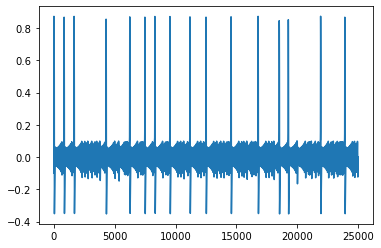

In [8]:
plt.plot(sol.t,sol.y[0])

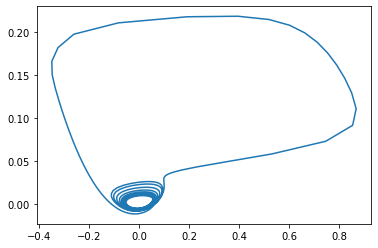

In [55]:
plt.plot(sol.y[0][200:600],sol.y[1][200:600])

In [9]:
#sol2 = solve_ivp(FHN, [2000, 25000], sol.y[:, 1000], 
 #                t_eval=np.array(range(2000, 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

In [10]:
#plt.plot(sol2.t + 2000,sol2.y[0])

In [11]:
T = [21100, 21920, 23260]
G = [0]

In [12]:
def FHN_sup(t, X):
    x1, y1, x2, y2 = X
    if G[0] < len(T) and np.abs(t - T[G[0]]) < 50:
        print(t)
        G[0] += 1  
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1) - 1e-3,
                    b1*x1 - c*y1,
                    x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                    b2*x2 - c*y2
                   ]
        
    return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                    b1*x1 - c*y1,
                    x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                    b2*x2 - c*y2
                   ]

In [13]:
sol_sup = solve_ivp(FHN_sup, [0, 25000], [-2.24, -3.31, 1.012, 5.123], 
                t_eval=np.array(range(0, 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

21050.246631242655
21870.072645659304
23210.081455186933


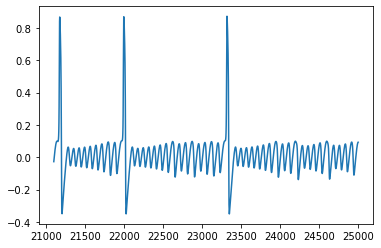

In [14]:
plt.plot(sol_sup.t[21100//2:] ,sol_sup.y[0][21100//2:])

In [15]:
#plt.plot(sol.t[10000:] ,test)

In [67]:
train = sol.y[:, 100:10000]
test = sol.y[:, 10000:] 
#test = sol2.y[0]

In [17]:
mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

In [57]:
W_in = np.random.uniform(-sigma, sigma, (1000, 4))

In [58]:
from skimage.io import imshow

In [59]:
def erdos_renyi(n=1000, p=0.6):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.random.uniform(0, 1) > p:
                a = np.random.uniform(-1, 1)
                A[i][j] = a
                A[j][i] = a
                
        A[i][i] = 0
            
    return A

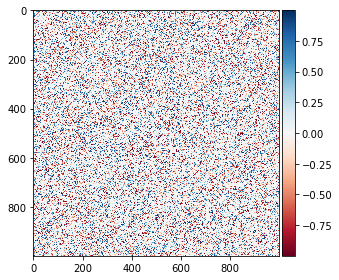

In [60]:
A = erdos_renyi()
imshow(A)

In [61]:
A = A/np.linalg.eig(A)[0].max()*1.6

In [62]:
np.linalg.eig(A)[0].max()

1.6000000000000028

In [114]:
def reservoir(U):
    r = np.random.uniform(1, -1, (1000, 1))
    R = np.zeros((1000, U.shape[1]))
    R[:, 0] = r[:, 0]
    for i in range(1, U.shape[1]):
        r = (1-alpha)*r + np.tanh(A@r + np.expand_dims(W_in@U[:, i], axis=1) + eps) #U[i] is a number
        R[:, i] = r[:, 0]
    return R

In [115]:
#R = reservoir(train)
R = reservoir(train)

In [116]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=beta)
reg.fit(R.T, train[0])

Ridge(alpha=1e-07)

In [123]:
def reservoir_step(r, v):
    print(v.shape, r.shape)
    return (1-alpha)*r + np.tanh(A@r + np.expand_dims(W_in@v, axis=1) + eps)

In [121]:
r = np.expand_dims(R[:, -1], axis=1)
def predict(r, v):
    r = reservoir_step(r, v)
    v_new = reg.predict(r.reshape((1, 1000)))
    return r, v_new

In [29]:
from IPython.display import clear_output


In [30]:
# all_rms = []
# for M in [10, 20, 25, 30]:
#     v = test[0]
#     predicted = []
#     rms = []
#     r = np.expand_dims(R[:, -1], axis=1)
#     for i in range(len(test)):
#         if i%M == 0 and i != 0:
#             rms.append((v-test[i])**2)
#             v = test[i]        
#         r, v = predict(r, v)
#         predicted.append(v)
#     all_rms.append(np.mean(rms)**0.5)

In [31]:
#all_rms

In [32]:
#plt.plot([10, 20, 25, 30], all_rms)

In [33]:
#np.mean(rms)**0.5

In [127]:
W_in@v

()

In [124]:
v = test[0]
predicted = []
rms = []
r = np.expand_dims(R[:, -1], axis=1)
#r = reservoir_step(r, train[-1])
r = reservoir_step(r, train[:, -1])
for i in range(len(test)):
    if 980 < i < 1100:
        v = test_norm[i] 
        predicted.append(mean + v*std)
        r, v = predict(r, v) 
    else:
        if i %10 == 0 and (i < 950 or i >=1100) and i <= 1930:
            v = test_norm[i] 
            predicted.append(mean + v*std)
            r, v = predict(r, v) 
        else:
        #if mean + v*sigmastest[i] < -800.2:
            
            r, v = predict(r, v)
                    #print(i%10, i, v, sigmastr[i])
            predicted.append(mean + v[0]*std)
        

(4,) (1000, 1)
() (1000, 1)


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [90]:
R[:, -1].shape

(1000,)

In [129]:
predicted = []
predicted_ee_all = []
M = 20
r = np.expand_dims(R[:, -1], axis=1)
#r = reservoir_step(r, train[-1])
r = reservoir_step(r, train[:, -1])
for i in range(len(test)):
    r_loop = r
    flag_ee = 0
    v = test[:, i] 
    predicted_ee = []
    for m in range(M): 
        r_loop, v = predict(r_loop, v)
        print(v.shape)
        predicted_ee.append(( v[0], i))
        if v[0] > 0.2:
            flag_ee = 1
        if m == M - 1 and flag_ee == 1:
            predicted_ee_all.append(predicted_ee)
    v = test[:, i] 
    r = reservoir_step(r, v)
    predicted.append(v[0])
        
        

(4,) (1000, 1)
(4,) (1000, 1)
(1,)
(1,) (1000, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 4)

In [36]:
predicted_ee_all

[[(0.10628612692942574, 948),
  (0.10770340328241174, 948),
  (0.10948630334399018, 948),
  (0.11168395098288819, 948),
  (0.11433345150699574, 948),
  (0.11745631370904745, 948),
  (0.12105587271454425, 948),
  (0.12511636512830937, 948),
  (0.12960537163811686, 948),
  (0.13448187462302907, 948),
  (0.13971203008619104, 948),
  (0.14529401147516124, 948),
  (0.15129247599668, 948),
  (0.1578830959638749, 948),
  (0.16540870494639517, 948),
  (0.17445059141777974, 948),
  (0.18591960406134228, 948),
  (0.2011711028321292, 948),
  (0.2221669902227596, 948),
  (0.2518932792131655, 948)],
 [(0.1104416504232114, 949),
  (0.11267181076551003, 949),
  (0.11537827194173907, 949),
  (0.11859862952049681, 949),
  (0.12235926559934511, 949),
  (0.12667089080635482, 949),
  (0.13152890161414332, 949),
  (0.1369204637261572, 949),
  (0.14284169466254523, 949),
  (0.14932848407967833, 949),
  (0.15650399529860712, 949),
  (0.16464579094775797, 949),
  (0.17427657775912367, 949),
  (0.1862836125257

Попробовать предсказывать только на 20 шагов вперед, но резервуар обновлять по u

In [37]:
v = test[0]
predicted = []
rms = []
r = np.expand_dims(R[:, -1], axis=1)
#r = reservoir_step(r, train[-1])
r = reservoir_step(r, train_norm[-1])
for i in range(len(test)):
    if  i <= 940:
        v = test_norm[i] 
        predicted.append(mean + v*std)
        r, v = predict(r, v) 
    else:
        #if mean + v*sigmastest[i] < -800.2:
        r, v = predict(r, v)
                    #print(i%10, i, v, sigmastr[i])
        predicted.append(mean + v[0]*std)

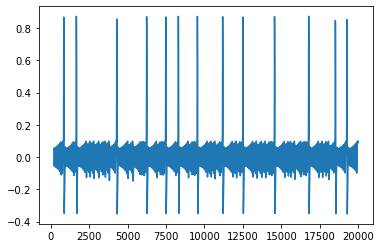

In [117]:
plt.plot(sol.t[100:10000], reg.predict(R.T))

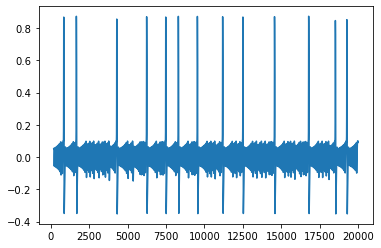

In [118]:
plt.plot(sol.t[100:10000], train[0])

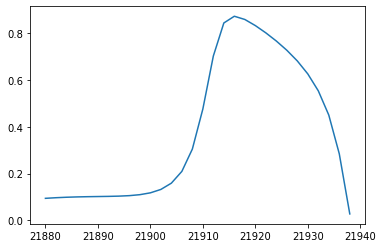

In [40]:
plt.plot(sol.t[10000:][940:970],test[940:970])
#plt.plot(sol2.t,test)

In [41]:
test[956]

0.7036032418892433

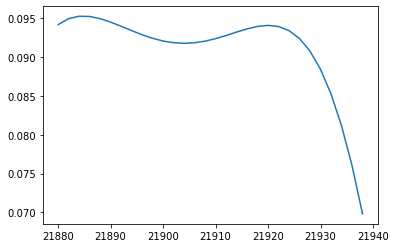

In [42]:
plt.plot(sol.t[10000:][940:970],predicted[:][940:970])
#plt.plot(sol2.t,predicted)

In [43]:
#plt.plot(sol.t[10000:], predicted)
#plt.plot(sol.t[10000:], test)

In [44]:
def FHN_correcting(t, X):    
        x1, y1, x2, y2 = X
        #if t == t_global or (-t + (np.array(T_events) - 50) < 1e-4).sum() > 0:
        if t == t_global-40:
            print(t)
            
            return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1) - 1,
                    b1*x1 - c*y1,
                    x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                    b2*x2 - c*y2
                   ]
        
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                    b1*x1 - c*y1,
                    x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                    b2*x2 - c*y2
                   ]

In [45]:
t_global = sol.t[10000:][950]

In [46]:
smth = solve_ivp(FHN_correcting, [sol.t[10000:][950]-40, 25000], sol.y[:, 10000:][:, 950], 
                             t_eval=np.array(range(sol.t[10000:][950], 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

21860.0


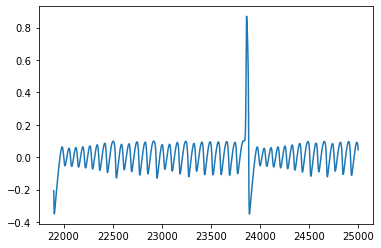

In [47]:
plt.plot(smth.t, smth.y[0])

In [48]:
C = 0 
 
def FHN_correcting(t, X):    
        x1, y1, x2, y2 = X
        if (-t + (np.array(T_events) - 50) < 1e-4).sum() > 0:
        #if t == t_global-40:
            print(t)
            
            return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1) - 1,
                    b1*x1 - c*y1,
                    x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                    b2*x2 - c*y2
                   ]
        
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                    b1*x1 - c*y1,
                    x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                    b2*x2 - c*y2
                   ]

In [49]:
T_events = []
i = 0
while i < len(test):
  if test[i] > 0.4:
    T_events.append(sol.t[10000:][i])
    i += 30
  i += 1

In [50]:
T_events

[21910, 23896]

In [51]:
sol.t[10000:][940:970],test[940:970]

(array([21880, 21882, 21884, 21886, 21888, 21890, 21892, 21894, 21896,
        21898, 21900, 21902, 21904, 21906, 21908, 21910, 21912, 21914,
        21916, 21918, 21920, 21922, 21924, 21926, 21928, 21930, 21932,
        21934, 21936, 21938]),
 array([0.09419739, 0.096839  , 0.09883375, 0.10025038, 0.10120502,
        0.10187885, 0.10254535, 0.10361596, 0.10572121, 0.10986373,
        0.1177212 , 0.13227455, 0.15916012, 0.20954854, 0.30510478,
        0.476622  , 0.70360324, 0.84501715, 0.87383811, 0.86002568,
        0.83389221, 0.80274267, 0.76776689, 0.72830412, 0.68252201,
        0.62690111, 0.55450003, 0.45063079, 0.28473903, 0.02747557]))

In [52]:
v = test[0]
new_data = sol.y[:, 10000:]
new_data_without_sup = sol.y[:, 10000:]
valid = []
predicted = []
rms = []
r = np.expand_dims(R[:, -1], axis=1)
r = reservoir_step(r, train_norm[-1])
t_global = 10002
M = 20
i = 0 
while i < len(new_data[0]):
    #if i%20 == 0 and i != 0:
        #rms.append((v-test[i])**2)
        #v = new_data[0, i] 
    r_loop = r
    v = (new_data[0][i] - mean)/std
    for m in range(M): 
        r_loop, v = predict(r_loop, v)
        if mean + v[0]*std > 0.2:
            print(m)
            new_data = solve_ivp(FHN_correcting, [t_global-40, 25000], new_data[:, i], 
                             t_eval=np.array(range(t_global, 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True).y
            new_data_without_sup = solve_ivp(FHN, [t_global-40, 25000], new_data_without_sup[:, i], 
                                          t_eval=np.array(range(t_global, 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True).y
            v = (new_data[0][0] - mean)/std
            i = 0
            break
    
    v = (new_data[0][i] - mean)/std 
    r = reservoir_step(r, v)
    predicted.append(mean + v*std)
    
    #r, v = predict(r, v)
    valid.append(new_data_without_sup[0][i])
    t_global += 2
    i += 1

17
21860.031584740576
21860.062066506784
21860.214475337816
21860.24157024111
21860.275438870227
21860.275438870227
21860.019392034093
21860.02481101475
21860.031584740576
21860.031584740576
21860.019392034097
21860.03158474058
21860.092548272994
21860.103386234314
21860.11693368596
21860.11693368596
21860.00232224502
21860.014514951505
21860.016682543766
21860.019392034097
21860.019392034097
21860.000859120242
21860.001346828503
21860.003785369798
21860.00421888825
21860.004760786316
21860.004760786316
21860.000078787027
21860.00017632868
21860.00066403694
21860.00075074063
21860.000859120242
21860.000859120242
21859.999922720384
21859.999942228715
21860.000039770366
21860.000057111105
21860.000078787027
21860.000078787027
21859.99991491705
21859.9999183852
21859.999922720384
21859.999922720384
21859.999914917058
21859.99992272039
21859.99996173706
21859.999968673357
21859.999977343727
21859.999977343727
21859.999902431726
21859.99990399239
21859.999911795723
21859.999913182983
21859.

21889.584533018216
21889.6014654877
21889.686127835124
21889.701178919113
21889.719992774095
21889.719992774095
21889.753913944915
21889.770874530324
21889.855677457377
21889.870753533298
21889.889598628197
21889.889598628197
21889.923576221496
21889.940565018147
21890.0255090014
21890.040610153977
21890.0594865947
21890.0594865947
21890.0935208016
21890.110537905053
21890.19562342231
21890.21074973649
21890.229657629214
21890.229657629214
21890.26374864226
21890.28079414878
21890.366021681395
21890.38117324275
21890.400112694442
21890.400112694442
21890.434260709306
21890.451334716738
21890.536704753897
21890.551881649393
21890.57085276876
21890.57085276876
21890.605057978937
21890.622160584026
21890.70767360947
21890.722875925105
21890.74187881965
21890.74187881965
21890.776141420884
21890.793272721505
21890.878929224597
21890.894157047365
21890.91319182583
21890.91319182583
21890.94751201395
21890.96467210801
21891.050472578303
21891.065725995246
21891.08479276642
21891.08479276642


21967.585401813914
21967.65838867154
21967.694882100357
21967.877349244427
21967.909787847817
21967.950336102054
21967.950336102054
21968.02358300304
21968.06020645353
21968.243323705992
21968.275877884207
21968.316570606978
21968.316570606978
21968.390079341963
21968.426833709458
21968.610605546924
21968.643276095805
21968.68411428191
21968.68411428191
21968.757886672618
21968.794772867972
21968.979203844738
21969.01199157394
21969.052976235445
21969.052976235445
21969.1270141165
21969.164033057026
21969.349127759662
21969.382033484577
21969.423165640717
21969.423165640717
21969.49747086426
21969.53462347603
21969.72038653488
21969.753411078676
21969.79469175842
21969.79469175842
21969.869266205613
21969.906553429213
21970.0929895472
21970.12613374595
21970.167563994393
21970.167563994393
21970.242409557664
21970.2798323393
21970.466946247474
21970.50021094226
21970.541791810745
21970.541791810745
21970.616910397548
21970.654469690948
21970.842266157953
21970.875652196533
21970.917384

22257.51414026702
22257.656344625546
22258.367366418166
22258.49377029241
22258.651775135215
22258.651775135215
22258.936167428397
22259.07836357499
22259.78934430795
22259.915740882694
22260.07373660113
22260.07373660113
22260.358144477657
22260.50034841592
22261.211368107237
22261.337771607916
22261.495775983763
22261.495775983763
22261.780216143492
22261.922436223354
22262.63353662267
22262.75995447144
22262.9179767824
22262.9179767824
22263.202431415728
22263.344658732392
22264.05579531572
22264.182219597198
22264.340249949048
22264.340249949048
22264.62468382181
22264.766900758194
22265.477985440102
22265.604400494663
22265.762419312865
22265.762419312865
22266.046824143938
22266.189026559474
22266.90003863716
22267.026440784302
22267.18444346823
22267.18444346823
22267.46884735897
22267.61104930434
22268.322059031194
22268.44846076041
22268.606462921933
22268.606462921933
22268.890897263533
22269.033114434333
22269.74420028833
22269.870615551263
22270.02863462993
22270.0286346299

22701.27859373714
22701.409719772797
22702.06534995107
22702.181906427206
22702.32760202238
22702.32760202238
22702.611734004902
22702.75379999616
22703.464129952466
22703.59041083359
22703.74826193499
22703.74826193499
22704.05691278649
22704.211238212243
22704.982865341
22705.120043497223
22705.2915161925
22705.2915161925
22705.59616772327
22705.748493488652
22706.510122315576
22706.645522995917
22706.814773846345
22706.814773846345
22707.09082450066
22707.22884982782
22707.91897646361
22708.041665643308
22708.195027117927
22708.195027117927
22708.453018274507
22708.582013852796
22709.226991744243
22709.3416544805
22709.484982900824
22709.484982900824
22709.755428701195
22709.89065160138
22710.566766102314
22710.686964235814
22710.837211902686
22710.837211902686
22711.1381760637
22711.28865814421
22712.04106854675
22712.17483039609
22712.342032707766
22712.342032707766
22712.655966289378
22712.812933080182
22713.597767034207
22713.73729307048
22713.91170061582
22713.91170061582
22714

23108.52416774074
23108.65689673603
23109.32054171248
23109.438523041626
23109.58599970306
23109.58599970306
23109.879942775493
23110.026914311708
23110.761771992784
23110.89241335831
23111.055715065217
23111.055715065217
23111.369390068263
23111.526227569786
23112.310415077405
23112.44982618987
23112.62409008045
23112.62409008045
23112.921968317518
23113.07090743605
23113.815603028717
23113.9479933563
23114.113481265784
23114.113481265784
23112.89040694433
23113.02356537627
23113.689357535965
23113.807720586577
23113.955674399844
23113.955674399844
23114.221991263723
23114.35514969566
23115.020941855357
23115.13930490597
23115.287258719236
23115.287258719236
23115.580777036248
23115.727536194754
23116.461331987288
23116.591784572625
23116.7548503043
23116.7548503043
23117.067143718774
23117.22329042601
23118.00402396219
23118.14282103529
23118.316317376662
23118.316317376662
23118.61357427546
23118.762202724858
23119.505344971847
23119.63745914909
23119.802601870644
23119.802601870644

23504.362664041568
23504.502450451528
23505.201382501342
23505.325637087975
23505.48095532127
23505.48095532127
23505.78943541945
23505.94367546854
23506.714875714
23506.851977979855
23507.02335581218
23507.02335581218
23507.333033946827
23507.487873014154
23508.262068350774
23508.399703077284
23508.57174648542
23508.57174648542
23508.85170101786
23508.99167828408
23509.69156461518
23509.815988851817
23509.971519147617
23509.971519147617
23510.22800284912
23510.35624469987
23510.997453953627
23511.11144670985
23511.25393765513
23511.25393765513
23511.51918734083
23511.651812183678
23512.31493639793
23512.43282514713
23512.58018608363
23512.58018608363
23512.87796672856
23513.026857051023
23513.771308663345
23513.903655616647
23514.069089308276
23514.069089308276
23514.38638887736
23514.5450386619
23515.338287584607
23515.47930961531
23515.65558715369
23515.65558715369
23515.952167736643
23516.100458028122
23516.841909485505
23516.97372307793
23517.138490068457
23517.138490068457
23515.

23888.83706365955
23888.98595855696
23889.73043304402
23889.862784063942
23890.028222838846
23890.028222838846
23890.345548189845
23890.504210865343
23891.297524242844
23891.438557732177
23891.614849593843
23891.614849593843
23891.911441749435
23892.059737827232
23892.801218216217
23892.933036952036
23893.097810371808
23893.097810371808
23891.876928654685
23892.007968185106
23892.663165837206
23892.779645419803
23892.925244898048
23892.925244898048
23893.18732395889
23893.31836348931
23893.97356114141
23894.090040724008
23894.235640202252
23894.235640202252
23894.530408212955
23894.677792218306
23895.414712245063
23895.54572024982
23895.709480255766
23895.709480255766
23896.027875197622
23896.18707266855
23896.983060023183
23897.124568886233
23897.30145496504
23897.30145496504
23897.60210501777
23897.752430044136
23898.504055175967
23898.637677421622
23898.804705228697
23898.804705228697
23897.565528757965
23897.697565654427
23898.357750136736
23898.475116266927
23898.62182392966
23898

24306.039100411494
24306.2949055704
24306.422808149855
24307.062321047128
24307.176012228865
24307.318126206035
24307.318126206035
24307.582875772765
24307.71525055613
24308.377124472958
24308.49479094706
24308.641874039688
24308.641874039688
24308.939936299786
24309.088967429834
24309.83412308008
24309.96659519568
24310.13218534018
24310.13218534018
24310.450326898004
24310.60939767692
24311.40475157148
24311.546147819405
24311.722893129307
24311.722893129307
24312.019818663623
24312.168281430782
24312.910595266578
24313.042562170718
24313.207520800894
24313.207520800894
24311.984490025294
24312.115288473284
24312.769280713248
24312.885546000354
24313.030877609235
24313.030877609235
24313.292474505222
24313.423272953212
24314.077265193177
24314.193530480283
24314.338862089164
24314.338862089164
24314.633851316674
24314.781345930427
24315.5188189992
24315.649925322537
24315.81380822671
24315.81380822671
24316.132977757916
24316.292562523522
24317.09048635154
24317.23233947652
24317.409

24706.08363494474
24706.08363494474
24706.349058957778
24706.4817709643
24707.145330996893
24707.26329722491
24707.41075500993
24707.41075500993
24707.70471778929
24707.85169917897
24708.586606127374
24708.717256251533
24708.880568906734
24708.880568906734
24709.19429868178
24709.351163569307
24710.135488006923
24710.2749234625
24710.44921778197
24710.44921778197
24710.747116329923
24710.8960656039
24711.640811973786
24711.773211328433
24711.93871052174
24711.93871052174
24710.715499464106
24710.848640305172
24711.514344510506
24711.632691924788
24711.78062619264
24711.78062619264
24712.046907874777
24712.180048715843
24712.845752921177
24712.96410033546
24713.112034603313
24713.112034603313
24713.405569137238
24713.5523364042
24714.286172739005
24714.416632531862
24714.57970727293
24714.57970727293
24714.892055457145
24715.048229549255
24715.829100009796
24715.967921425003
24716.141448194012
24716.141448194012
24716.438729260037
24716.58736979305
24717.33057245812
24717.46269737635
24

6
21860.114683348413
21860.14501923564
21860.18293909467
21860.18293909467
21860.0472459136
21860.08178294245
21860.254468086685
21860.28516766788
21860.32354214438
21860.32354214438
21860.03343110206
21860.0395710183
21860.0472459136
21860.0472459136
21860.00303851668
21860.004266499927
21860.005801478987
21860.005801478987
21860.003038516676
21860.005801478983
21860.01961629052
21860.022072257016
21860.025142215134
21860.025142215134
21860.001933331754
21860.002424525053
21860.003038516676
21860.003038516676
21860.001933331747
21860.00303851667
21860.008564441276
21860.009546827874
21860.01077481112
21860.01077481112
21860.00016503587
21860.000386072858
21860.00149125778
21860.001687735097
21860.001933331747
21860.001933331747
21860.00007662108
21860.00011591654
21860.00016503587
21860.00016503587
21860.000076621072
21860.000165035864
21860.000607109825
21860.00068570075
21860.00078393941
21860.00078393941
21859.999935157404
21859.999952840364
21860.000041255156
21860.000056973342
21

21889.395841026846
21889.412716561514
21889.497094234845
21889.512094710102
21889.530845304176
21889.530845304176
21889.564652233712
21889.58155569848
21889.666073022327
21889.68109832434
21889.699879951862
21889.699879951862
21889.733742930424
21889.750674419705
21889.835331866107
21889.850382078803
21889.86919484467
21889.86919484467
21889.90311406195
21889.920073670593
21890.0048717138
21890.019946921482
21890.038790931085
21890.038790931085
21890.072766578243
21890.08975440182
21890.17469351971
21890.189793807338
21890.20866916687
21890.20866916687
21890.2427014349
21890.25971756892
21890.344798239
21890.359923691456
21890.37883050703
21890.37883050703
21890.41291958989
21890.42996413132
21890.51518683847
21890.530337541964
21890.54927592133
21890.54927592133
21890.583422013155
21890.600495059065
21890.68586028862
21890.701036329432
21890.720006380445
21890.720006380445
21890.754209674735
21890.771311321878
21890.856819557597
21890.872021021725
21890.891022851887
21890.891022851887

21971.17661118965
21971.36507090238
21971.398574851308
21971.44045478747
21971.44045478747
21971.51611539585
21971.55394570004
21971.74309722099
21971.77672415805
21971.818757829373
21971.818757829373
21971.894697129952
21971.932666780238
21972.122515031682
21972.15626583194
21972.19845433226
21972.19845433226
21972.27467431712
21972.31278430955
21972.5033342717
21972.537209820526
21972.579554256557
21972.579554256557
21972.656056933713
21972.694308272294
21972.885564965185
21972.91956615503
21972.96206764234
21972.96206764234
21973.03885504668
21973.07724874885
21973.2692172597
21973.303344994965
21973.346004664043
21973.346004664043
21973.42307883898
21973.461615926448
21973.654301363786
21973.688556552646
21973.731375538722
21973.731375538722
21973.808738562
21973.84742007364
21974.040827631827
21974.075211197727
21974.118190655103
21974.118190655103
21974.195844634538
21974.234671624254
21974.42880657284
21974.46331945259
21974.506460552275
21974.506460552275
21974.584407592505
219

22281.73366891153
22281.875896227968
22282.587032810166
22282.71345709145
22282.871487443048
22282.871487443048
22283.15593574847
22283.298159901176
22284.009280664726
22284.135702133804
22284.293728970148
22284.293728970148
22284.578160456575
22284.720376199788
22285.43145491585
22285.55786890982
22285.71588640228
22285.71588640228
22286.000311093012
22286.14252343838
22286.853585165212
22286.97999613887
22287.138009855946
22287.138009855946
22287.422446605182
22287.5646649798
22288.275756852894
22288.40217318589
22288.56019360213
22288.56019360213
22288.844649047078
22288.986876769555
22289.698015381928
22289.824440024127
22289.982470826875
22289.982470826875
22290.266928651323
22290.409157563547
22291.120302124662
22291.24672782442
22291.40475994911
22291.40475994911
22291.68920360194
22291.831425428354
22292.54253456043
22292.66895396169
22292.826978213263
22292.826978213263
22293.111405527532
22293.253619184667
22293.964687470343
22294.091099610017
22294.249114784612
22294.2491147

22739.707141923405
22739.857979962188
22740.61217015611
22740.74624841281
22740.913846233678
22740.913846233678
22741.200741158675
22741.344188621177
22742.061425933673
22742.188934789225
22742.34832085867
22742.34832085867
22742.61752053175
22742.752120368288
22743.42511955099
22743.544763850135
22743.69431922407
22743.69431922407
22743.963582812125
22744.09821460615
22744.77137357629
22744.891046282093
22745.040637164348
22745.040637164348
22745.328205497877
22745.471989664646
22746.190910498473
22746.318718646708
22746.478478832003
22746.478478832003
22746.782157375143
22746.933996646712
22747.69319300456
22747.828161245958
22747.9968715477
22747.9968715477
22748.293718512068
22748.442141994252
22749.184259405174
22749.31619138934
22749.48110636954
22749.48110636954
22749.756058633477
22749.893534765444
22750.580915425286
22750.70311643148
22750.85586768922
22750.85586768922
22751.12022588954
22751.252404989697
22751.913300490487
22752.03079302396
22752.177658690805
22752.1776586908

23139.79146336419
23139.92410013292
23140.587283976573
23140.705183326554
23140.852557514034
23140.852557514034
23141.150318894997
23141.29919958548
23142.043603037888
23142.17594142943
23142.34136441885
23142.34136441885
23142.658617715162
23142.817244363316
23143.610377604095
23143.751379069123
23143.927630900405
23143.927630900405
23144.22419835552
23144.37248208308
23145.113900720873
23145.245708478702
23145.41046817599
23145.41046817599
23144.189757073793
23144.32082016049
23144.976135593963
23145.092636115467
23145.23826176735
23145.23826176735
23145.500387940738
23145.631451027435
23146.286766460908
23146.403266982412
23146.548892634295
23146.548892634295
23146.84364025745
23146.991014069034
23147.72788312693
23147.85888207055
23148.022630750085
23148.022630750085
23148.34095443867
23148.50011628296
23149.295925504422
23149.43740269935
23149.614249193008
23149.614249193008
23149.914867393923
23150.065176494383
23150.81672199667
23150.950330085965
23151.117340197587
23151.1173401

23531.566365312345
23531.715771556206
23532.46280277551
23532.595608325606
23532.76161526323
23532.76161526323
23531.532413943787
23531.664844503368
23532.326997301272
23532.444713354234
23532.591858420434
23532.591858420434
23532.856719539595
23532.989150099176
23533.65130289708
23533.769018950043
23533.916164016242
23533.916164016242
23534.210356021194
23534.357452023673
23535.092932036052
23535.223684038254
23535.387124041004
23535.387124041004
23535.701717070275
23535.859013584908
23536.645496158086
23536.785315282206
23536.960089187356
23536.960089187356
23537.2584131041
23537.407575062476
23538.15338485434
23538.28597326178
23538.451708771085
23538.451708771085
23537.225898044988
23537.358802473802
23538.02332461788
23538.14146188794
23538.28913347551
23538.28913347551
23538.554942333143
23538.687846761957
23539.352368906035
23539.470506176094
23539.618177763667
23539.618177763667
23539.91195304079
23540.058840679358
23540.793278872174
23540.923845662008
23541.0870541493
23541.08

23950.10940314728
23950.267779875223
23951.059663514952
23951.200442828682
23951.376416970845
23951.376416970845
23951.675549980166
23951.825116484826
23952.57294900813
23952.70589701227
23952.87208201745
23952.87208201745
23951.64086145998
23951.773083704546
23952.43419492738
23952.55172581144
23952.698639416514
23952.698639416514
23952.963083905648
23953.095306150215
23953.75641737305
23953.87394825711
23954.020861862184
23954.020861862184
23954.31525579638
23954.46245276348
23955.198437598978
23955.32927934751
23955.492831533174
23955.492831533174
23955.808096932335
23955.965729631913
23956.753893129808
23956.89401108499
23957.069158528968
23957.069158528968
23957.367788811196
23957.51710395231
23958.263679657874
23958.396404227755
23958.562309940102
23958.562309940102
23957.334580337505
23957.467291241774
23958.130845763113
23958.24881101135
23958.39626757165
23958.39626757165
23958.661689380187
23958.794400284456
23959.457954805795
23959.575920054034
23959.723376614333
23959.72337

24353.186591305213
24353.31598978172
24353.96298216427
24354.078003032282
24354.22177911729
24354.22177911729
24354.50135145684
24354.641137626615
24355.34006847549
24355.464322848624
24355.61964081504
24355.61964081504
24355.92811910568
24356.082358251
24356.853553977595
24356.990655440102
24357.162032268236
24357.162032268236
24357.47170784938
24357.626545639956
24358.40073459282
24358.53836818444
24358.710410173964
24358.710410173964
24358.990365889476
24359.13034374723
24359.830233036006
24359.954657798455
24360.110188751518
24360.110188751518
24360.366674897155
24360.494917969976
24361.13613333407
24361.250127176572
24361.392619479706
24361.392619479706
24361.657869667168
24361.7904947609
24362.45362022955
24362.571509201756
24362.71887041701
24362.71887041701
24363.0166500837
24363.16553991704
24363.90998908376
24364.04233560229
24364.20776875045
24364.20776875045
24364.52506244162
24364.6837092872
24365.476943515117
24365.617962933415
24365.794237206286
24365.794237206286
24366.

24743.32584481466
24743.456887380526
24744.112100209866
24744.22858249064
24744.374185341603
24744.374185341603
24744.66895464533
24744.816339297195
24745.55326255651
24745.684271135946
24745.848031860238
24745.848031860238
24746.166422100192
24746.32561722017
24747.121592820058
24747.263099593372
24747.439983060012
24747.439983060012
24747.740628605785
24747.89095137867
24748.642565243106
24748.776185485673
24748.94321078888
24748.94321078888
24747.70405678239
24747.83609364358
24748.49627794952
24748.613644048357
24748.7603516719
24748.7603516719
24749.024425394276
24749.156462255465
24749.81664656141
24749.934012660244
24750.080720283786
24750.080720283786
24750.375506686676
24750.522899888118
24751.25986589534
24751.390882074404
24751.55465229823
24751.55465229823
24751.87070033299
24752.02872435037
24752.818844437275
24752.959310230504
24753.134892472037
24753.134892472037
24753.43370734763
24753.583114785426
24754.330151974413
24754.462958585787
24754.628966850007
24754.628966850

15
21860.032647853768
21860.05082533627
21860.073547189397
21860.073547189397
21860.013089415683
21860.11682313763
21860.135264688197
21860.158316626406
21860.158316626406
21860.00064136905
21860.00479071793
21860.02553746232
21860.029225772432
21860.033836160073
21860.033836160073
21860.00064136905
21860.00064136905
21860.000641369053
21860.00894006681
21860.010415390858
21860.012259545914
21860.012259545914
21859.99997747323
21860.001637212783
21860.001932277595
21860.002301108605
21860.002301108605
21860.00017664198
21860.000235654945
21860.000309421146
21860.000309421146
21859.999911083654
21859.999911083654
21859.999911083658
21860.000043862827
21860.000067468012
21860.000096974494
21860.000096974494
21859.999900461324
21859.999927017157
21859.999931738195
21859.99993763949
21859.99993763949
21859.999903648026
21859.999904592234
21859.999905772493
21859.999905772493
21859.999904057822
21859.99990628474
21859.999917419318
21859.9999193988
21859.99992187315
21859.99992187315
21859.9

21887.735505348006
21887.75199184019
21887.83442430111
21887.84907896083
21887.867397285478
21887.867397285478
21887.9004235032
21887.916936612062
21887.999502156374
21888.014180475362
21888.032528374097
21888.032528374097
21888.06560800092
21888.082147814333
21888.16484688139
21888.17954893776
21888.197926508215
21888.197926508215
21888.231059721158
21888.24762632763
21888.33045935999
21888.345185232407
21888.363592572932
21888.363592572932
21888.39677954806
21888.413373035626
21888.496340473444
21888.51109024017
21888.529527448572
21888.529527448572
21888.562768366304
21888.57938882517
21888.662491119496
21888.67726486071
21888.695732037228
21888.695732037228
21888.72902707497
21888.74567459384
21888.828912188193
21888.843709982746
21888.862207225935
21888.862207225935
21888.895556564607
21888.912231233946
21888.99560458063
21889.010426508925
21889.0289539193
21889.0289539193
21889.062357739163
21889.0790596491
21889.16256919876
21889.17741534092
21889.195973018624
21889.195973018624

21966.820697818825
21966.852532034394
21966.89232480386
21966.89232480386
21966.96420261889
21967.000141526405
21967.17983606398
21967.21178175955
21967.25171387901
21967.25171387901
21967.323844225997
21967.35990939949
21967.54023526695
21967.572293198948
21967.61236561394
21967.61236561394
21967.68475022272
21967.72094252711
21967.90190404906
21967.934074986297
21967.974288657842
21967.974288657842
21968.046929273696
21968.083249581625
21968.26485112126
21968.297135839417
21968.337491737115
21968.337491737115
21968.410390113746
21968.44683930206
21968.629085243643
21968.661484522145
21968.701983620274
21968.701983620274
21968.775141542086
21968.811720502992
21968.994615307518
21969.027129939434
21969.06777322933
21969.06777322933
21969.141192490602
21969.177902121235
21969.361450274413
21969.394081057202
21969.434869535686
21969.434869535686
21969.50855195764
21969.545393168617
21969.7295992235
21969.762346966592
21969.803281645454
21969.803281645454
21969.877229047237
21969.91420274

22259.40810830207
22259.550315285887
22260.261350204994
22260.387756412834
22260.545764172635
22260.545764172635
22260.83021503705
22260.972440469257
22261.683567630294
22261.809990236703
22261.96801849471
22261.96801849471
22262.25247145472
22262.394697934727
22263.105830334753
22263.232253872535
22263.390283294764
22263.390283294764
22263.67470018713
22263.816908633315
22264.527950864234
22264.65435837195
22264.8123677566
22264.8123677566
22265.09675430321
22265.238947576516
22265.949913943037
22266.07630796375
22266.234300489647
22266.234300489647
22266.518703281516
22266.660904677454
22267.37191165713
22267.49831289796
22267.656314449
22267.656314449
22267.94076549904
22268.082991024057
22268.794118649155
22268.920541338062
22269.078569699195
22269.078569699195
22269.36304478931
22269.50528233436
22270.21647005964
22270.342903433026
22270.500945149754
22270.500945149754
22270.78539273027
22270.92761652053
22271.63873547182
22271.76515661872
22271.92318305234
22271.92318305234
22272

22721.62942428733
22721.764540187465
22722.440119688134
22722.560222710476
22722.7103514884
22722.7103514884
22723.012033535102
22723.162874558453
22723.917079675208
22724.05116058485
22724.21876172191
22724.21876172191
22724.53356544942
22724.690967313174
22725.47797663195
22725.617889399735
22725.79278035946
22725.79278035946
22726.08338739256
22726.228690909105
22726.955208491847
22727.084367173225
22727.245815524944
22727.245815524944
22726.052704207374
22726.18266613133
22726.832475751115
22726.9479974613
22727.092399599027
22727.092399599027
22727.35232344694
22727.482285370897
22728.13209499068
22728.247616700864
22728.392018838593
22728.392018838593
22728.686469305627
22728.833694539142
22729.56982070673
22729.700687580967
22729.864271173763
22729.864271173763
22730.1849565199
22730.34529919297
22731.147012558315
22731.28953937882
22731.467697904453
22731.467697904453
22731.77046219449
22731.92184433951
22732.67875506461
22732.813316971293
22732.98151935465
22732.98151935465
22

23114.70362167966
23114.835671444747
23115.495920270205
23115.613297839176
23115.76001980039
23115.76001980039
23116.05479188183
23116.20217792255
23116.939108126156
23117.07011794013
23117.233880207597
23117.233880207597
23117.549887271405
23117.707890803307
23118.497908462825
23118.63835604674
23118.813915526633
23118.813915526633
23119.11271409412
23119.262113377867
23120.00910979659
23120.141909159916
23120.307908364077
23120.307908364077
23119.0787890446
23119.211225803585
23119.873409598502
23119.991131162045
23120.13828311647
23120.13828311647
23120.40315663444
23120.535593393422
23121.19777718834
23121.315498751883
23121.462650706308
23121.462650706308
23121.75683605656
23121.90392873169
23122.63939210732
23122.77014115188
23122.933577457574
23122.933577457574
23123.248149879924
23123.405436091096
23124.19186714697
23124.33167711246
23124.50643956932
23124.50643956932
23124.804756470377
23124.953914920905
23125.699707173546
23125.832292462906
23125.998024074604
23125.9980240746

23523.135685643912
23523.135685643912
23523.400435210642
23523.53280999401
23524.194683910835
23524.31235038494
23524.459433477565
23524.459433477565
23524.757495737664
23524.90652686771
23525.651682517957
23525.78415463356
23525.949744778056
23525.949744778056
23526.26788633588
23526.426957114796
23527.22231100936
23527.363707257282
23527.540452567184
23527.540452567184
23527.8373781015
23527.98584086866
23528.728154704455
23528.860121608595
23529.02508023877
23529.02508023877
23527.80204946317
23527.93284791116
23528.586840151125
23528.70310543823
23528.848437047112
23528.848437047112
23529.1100339431
23529.24083239109
23529.894824631054
23530.01108991816
23530.15642152704
23530.15642152704
23530.45141075455
23530.598905368304
23531.336378437078
23531.467484760415
23531.631367664588
23531.631367664588
23531.950537195793
23532.1101219614
23532.908045789416
23533.049898914396
23533.22721532062
23533.22721532062
23533.52822595643
23533.678731274336
23534.431257863864
23534.565040368667


23955.81538921654
23955.960993976118
23955.960993976118
23956.255760422664
23956.403143645937
23957.1400597623
23957.271067071877
23957.434826208846
23957.434826208846
23957.753208788916
23957.91240007895
23958.708356529118
23958.849859898037
23959.026739109187
23959.026739109187
23959.327383061995
23959.4777050384
23960.229314920423
23960.362934455003
23960.52995887323
23960.52995887323
23959.290819566955
23959.42285979584
23960.083060940255
23960.200430032597
23960.347141398022
23960.347141398022
23960.61122185579
23960.743262084674
23961.40346322909
23961.520832321432
23961.667543686857
23961.667543686857
23961.962321683823
23962.109710682307
23962.846655674723
23962.97766811782
23963.141433671688
23963.141433671688
23963.45746565802
23963.615481651184
23964.40556161701
23964.546020277605
23964.721593603343
23964.721593603343
23965.02040527716
23965.16981111407
23965.91684029861
23966.04964548697
23966.215651972427
23966.215651972427
23964.986455351343
23965.118886225344
23965.78104

24347.96819408849
24348.10109110269
24348.765576173693
24348.883706852983
24349.031370202094
24349.031370202094
24349.325150588327
24349.472040781446
24350.206491747034
24350.337060807582
24350.500272133268
24350.500272133268
24350.81340670557
24350.96997399172
24351.752810422473
24351.891981343495
24352.065944994774
24352.065944994774
24352.363575567262
24352.51239085351
24353.256467284733
24353.38874753917
24353.55409785722
24353.55409785722
24352.332573272004
24352.46588741062
24353.132458103697
24353.250959560242
24353.399086380927
24353.399086380927
24353.665714658157
24353.799028796773
24354.46559948985
24354.584100946395
24354.73222776708
24354.73222776708
24355.025591592042
24355.172273504526
24355.905683066936
24356.03606698914
24356.1990468919
24356.1990468919
24356.51083959072
24356.666735940125
24357.44621768717
24357.58479221998
24357.75801038599
24357.75801038599
24358.055041455995
24358.203556990993
24358.946134666
24359.07814847489
24359.243165736003
24359.243165736003


24741.083183748313
24741.238364885256
24742.01427056997
24742.152209358363
24742.324632843854
24742.324632843854
24742.60448942778
24742.744417719743
24743.444059179557
24743.568439883526
24743.723915763483
24743.723915763483
24743.979715677655
24744.10761563474
24744.747115420167
24744.86080427091
24745.00291533434
24745.00291533434
24745.267664671184
24745.400039339605
24746.061912681722
24746.179579053653
24746.326662018568
24746.326662018568
24746.62473077315
24746.773765150443
24747.518937036897
24747.651412038933
24747.81700579148
24747.81700579148
24748.135151302376
24748.294224057827
24749.089587835068
24749.23098583991
24749.407733345965
24749.407733345965
24749.704656549704
24749.853118151572
24750.595426160915
24750.727392029243
24750.892349364654
24750.892349364654
24749.66932324935
24749.800118201038
24750.454092959495
24750.570355138778
24750.71568286288
24750.71568286288
24750.977272766264
24751.108067717953
24751.76204247641
24751.878304655693
24752.023632379794
24752.0

14
21860.002486807316
21860.039672710725
21860.08615508999
21860.08615508999
21860.170898926342
21860.20820433572
21860.254836097436
21860.254836097436
21860.00302458416
21860.00302458416
21860.00302458416
21860.086961755253
21860.101883919004
21860.12053662369
21860.12053662369
21860.01309704469
21860.01608147744
21860.019812018378
21860.019812018378
21860.013097044684
21860.01981201837
21860.0533868868
21860.0593557523
21860.066816834173
21860.066816834173
21860.002353086787
21860.003696081523
21860.01041105521
21860.01160482831
21860.013097044684
21860.013097044684
21860.000204295207
21860.000472894157
21860.001815888892
21860.00205464351
21860.002353086787
21860.002353086787
21860.000096855627
21860.00014460655
21860.000204295207
21860.000204295207
21860.000096855634
21860.000204295215
21860.000741493117
21860.000836994965
21860.000956372278
21860.000956372278
21859.999924952306
21859.99994644022
21860.0000538798
21860.000072980172
21860.000096855634
21860.000096855634
21859.999916

21889.002752468794
21889.01974348622
21889.104698573345
21889.119801699944
21889.138680608194
21889.138680608194
21889.172719297127
21889.189738641595
21889.274835363933
21889.289963670126
21889.308874052866
21889.308874052866
21889.34296958849
21889.360017356303
21889.445256195362
21889.46040976675
21889.479351730988
21889.479351730988
21889.51350430747
21889.530580595707
21889.615962036907
21889.631140959787
21889.65011461339
21889.65011461339
21889.6843244252
21889.701429331108
21889.786953860643
21889.80215822145
21889.821163672455
21889.821163672455
21889.855430916563
21889.87256453862
21889.95823264889
21889.97346253516
21889.992499892996
21889.992499892996
21890.026824765617
21890.04398720193
21890.129799383485
21890.145054882425
21890.164124256105
21890.164124256105
21890.198506954734
21890.215698304044
21890.30165505061
21890.31693625
21890.33603774924
21890.33603774924
21890.370478474262
21890.387698836774
21890.47380064933
21890.48910763823
21890.508241374355
21890.508241374

21963.88307076494
21963.91856603103
21964.09604236146
21964.12759370909
21964.16703289363
21964.16703289363
21964.238269659403
21964.27388804229
21964.451979956724
21964.483640741513
21964.523216722497
21964.523216722497
21964.59470138236
21964.630443712296
21964.80915536196
21964.8409263219
21964.880640021824
21964.880640021824
21964.952374251025
21964.988241365623
21965.167576938627
21965.19945881827
21965.23931116783
21965.23931116783
21965.311296667092
21965.34728941672
21965.527253164877
21965.559246720106
21965.59923866414
21965.59923866414
21965.671477140128
21965.707596378124
21965.888192568094
21965.92029855742
21965.96043104408
21965.96043104408
21966.032924230196
21966.06917082325
21966.250403788537
21966.282622982366
21966.322896974652
21966.322896974652
21966.39564661391
21966.43202143354
21966.61389553168
21966.64622870468
21966.686645170936
21966.686645170936
21966.75965302446
21966.79615695122
21966.97867658503
21967.01112451993
21967.051684438553
21967.051684438553
219

22249.467781387808
22249.609983071023
22250.320991487082
22250.447392983267
22250.605394853505
22250.605394853505
22250.889802713882
22251.03200664407
22251.74302629501
22251.869429788512
22252.02743415539
22252.02743415539
22252.311842937004
22252.45404732781
22253.165069281844
22253.291473184785
22253.44947806346
22253.44947806346
22253.733888941304
22253.876094380226
22254.587121574838
22254.713526409436
22254.871532452682
22254.871532452682
22255.15594648452
22255.29815350044
22256.00918858004
22256.13559481641
22256.293602611877
22256.293602611877
22256.5780207492
22256.72022981786
22257.431275161165
22257.557683222196
22257.715693298487
22257.715693298487
22258.00011598854
22258.142327333568
22258.853384058697
22258.979794143164
22259.13780674875
22259.13780674875
22259.422229532553
22259.564440924452
22260.27549788396
22260.401908010095
22260.55992066776
22260.55992066776
22260.844341184467
22260.98655144282
22261.697602734585
22261.82401185312
22261.98202325129
22261.9820232512

22725.956847988018
22726.096107150614
22726.792402963605
22726.916188885916
22727.070921288803
22727.070921288803
22727.346619054744
22727.484467937717
22728.173712352575
22728.296244692992
22728.449410118516
22728.449410118516
22728.732695628918
22728.87433838412
22729.582552160133
22729.70845683142
22729.865837670535
22729.865837670535
22730.158647289936
22730.305052099637
22731.037076148143
22731.167213756766
22731.329885767544
22731.329885767544
22731.62249713457
22731.768802818086
22732.500331235653
22732.63038073211
22732.79294260268
22732.79294260268
22733.07539861431
22733.216626620124
22733.9227666492
22734.04830265437
22734.205222660832
22734.205222660832
22734.479724380293
22734.616975240024
22735.30322953868
22735.425230302884
22735.57773125814
22735.57773125814
22735.855915095606
22735.99500701434
22736.690466608
22736.814103869096
22736.968650445466
22736.968650445466
22737.258355503447
22737.403208032436
22738.127470677387
22738.256228480936
22738.41717573537
22738.41717

23141.772070453622
23141.921464099207
23142.66843232712
23142.80122667875
23142.967219618284
23142.967219618284
23141.738173880483
23141.870619239497
23142.532846034563
23142.650575242573
23142.79773675259
23142.79773675259
23143.062627470616
23143.19507282963
23143.857299624695
23143.975028832705
23144.12219034272
23144.12219034272
23144.416368079277
23144.56345694755
23145.298901288937
23145.42964694963
23145.593079025493
23145.593079025493
23145.907625040087
23146.064898047385
23146.85126308387
23146.99106131258
23147.165809098464
23147.165809098464
23147.464114029277
23147.61326649468
23148.35902882171
23148.49160879096
23148.657333752522
23148.657333752522
23147.43164585811
23147.564564237935
23148.22915613705
23148.347305808005
23148.494992896696
23148.494992896696
23148.76082965634
23148.893748036167
23149.558339935284
23149.676489606238
23149.82417669493
23149.82417669493
23150.117938237036
23150.264819008087
23150.999222863356
23151.12978354874
23151.292984405463
23151.2929844

23527.56445213131
23527.721005053685
23528.50376966556
23528.642927818782
23528.81687551031
23528.81687551031
23529.114491876873
23529.263300060156
23530.007340976565
23530.139614917258
23530.304957343127
23530.304957343127
23529.083520196895
23529.216842540187
23529.883454256644
23530.001963006238
23530.150098943228
23530.150098943228
23530.416743629812
23530.550065973104
23531.21667768956
23531.335186439155
23531.483322376145
23531.483322376145
23531.776676921938
23531.923354194834
23532.65674055932
23532.78712035745
23532.950095105112
23532.950095105112
23533.261863285737
23533.41774737605
23534.19716782761
23534.335731463445
23534.508936008235
23534.508936008235
23534.805959609865
23534.954471410678
23535.69703041475
23535.829040904366
23535.99405401638
23535.99405401638
23536.26149021991
23536.39520832167
23537.06379883049
23537.182659365393
23537.33123503402
23537.33123503402
23537.589380152807
23537.7184527122
23538.36381550917
23538.478546673075
23538.621960627956
23538.6219606

23954.305219882015
23954.44403494086
23954.61755376442
23954.61755376442
23954.914829497906
23955.063467364653
23955.806656698373
23955.93877924659
23956.10393243186
23956.10393243186
23954.884655219535
23955.01820594709
23955.685959584876
23955.804671342707
23955.953061039992
23955.953061039992
23956.22016249511
23956.353713222663
23957.02146686045
23957.14017861828
23957.288568315565
23957.288568315565
23957.581704147768
23957.72827206387
23958.46111164437
23958.59139423646
23958.754247476572
23958.754247476572
23959.065293079067
23959.220815880315
23959.998429886557
23960.136672376553
23960.30947548905
23960.30947548905
23960.60616670448
23960.754512312196
23961.49624035077
23961.628103113184
23961.7929315662
23961.7929315662
23962.06078741856
23962.194715344736
23962.864354975627
23962.98340202112
23963.132210827986
23963.132210827986
23963.391003906647
23963.520400445977
23964.167383142627
23964.2824022887
23964.42617622129
23964.42617622129
23964.705745677966
23964.845530406306
2

24361.594970454313
24361.758736297532
24361.758736297532
24362.07476870788
24362.232784913052
24363.02286593892
24363.163324787965
24363.33889834927
24363.33889834927
24363.637709205
24363.78711463286
24364.53414177218
24364.66694659695
24364.83295262791
24364.83295262791
24363.60375819425
24363.73618811674
24364.39833772919
24364.51605321585
24364.663197574173
24364.663197574173
24364.928057419154
24365.060487341645
24365.722636954095
24365.840352440755
24365.987496799076
24365.987496799076
24366.281688033367
24366.428783650514
24367.16426173624
24367.295013395924
24367.45845297053
24367.45845297053
24367.773048209667
24367.930345829234
24368.716833927072
24368.856654033356
24369.031429166207
24369.031429166207
24369.329757286694
24369.478921346938
24370.22474164816
24370.35733192393
24370.523069768646
24370.523069768646
24369.297238022467
24369.430142450597
24370.09466459125
24370.2128018607
24370.360473447512
24370.360473447512
24370.626282303772
24370.759186731902
24371.42370887255

24749.430437068346
24749.586990099415
24750.369755254764
24750.508913504604
24750.682861316905
24750.682861316905
24750.980477764224
24751.129285987885
24751.873327106186
24752.005601082772
24752.170943553505
24752.170943553505
24750.949506300763
24751.08282879269
24751.74944125233
24751.867950134045
24752.016086236188
24752.016086236188
24752.282731220046
24752.41605371197
24753.082666171613
24753.201175053327
24753.34931115547
24753.34931115547
24753.64266666175
24753.78934441489
24754.52273318059
24754.653113405606
24754.81608868687
24754.81608868687
24755.127856017654
24755.283739683044
24756.06315801
24756.201721268128
24756.374925340784
24756.374925340784
24756.671947807597
24756.820459041006
24757.563015208045
24757.695025193294
24757.860037674858
24757.860037674858
24758.127472928638
24758.261190555524
24758.92977868997
24759.04863880276
24759.19721394375
24759.19721394375
24759.455359915097
24759.58443290077
24760.229797829135
24760.344529371956
24760.487943800483
24760.487943

13
21860.11078450185
21860.149306994434
21860.197460110165
21860.197460110165
21860.016628879534
21860.056226676686
21860.254215662466
21860.289413704384
21860.33341125678
21860.33341125678
21860.00078976067
21860.007829369053
21860.016628879534
21860.016628879534
21860.000789760674
21860.016628879537
21860.095824473854
21860.10990369062
21860.12750271158
21860.12750271158
21860.000789760674
21860.000789760674
21860.000789760667
21860.032467998386
21860.03809968509
21860.045139293474
21860.045139293474
21860.004591149194
21860.005717486532
21860.00712540821
21860.00712540821
21860.004591149187
21860.007125408203
21860.019796703284
21860.022049377963
21860.024865221316
21860.024865221316
21860.000536334763
21860.001043186563
21860.00357744558
21860.004027980518
21860.004591149187
21860.004591149187
21860.000333594042
21860.00042370103
21860.000536334763
21860.000536334763
21859.99990558585
21859.999928112597
21859.999928112597
21859.999928112597
21860.000130853317
21860.000166896112
218

21890.377915712226
21890.461758296435
21890.47666364474
21890.495295330118
21890.495295330118
21890.528887467106
21890.545683535598
21890.629663878062
21890.644593716723
21890.66325601505
21890.66325601505
21890.696903439744
21890.71372715209
21890.797845713823
21890.8128001248
21890.831493138518
21890.831493138518
21890.86519603803
21890.882047487787
21890.966304736572
21890.981283803023
21891.000007636085
21891.000007636085
21891.03376619668
21891.050645476975
21891.13504187846
21891.15004568317
21891.168800439056
21891.168800439056
21891.20261484848
21891.21952205319
21891.304058076745
21891.319086703155
21891.33787248617
21891.33787248617
21891.371742932726
21891.388678156003
21891.473354272395
21891.488407804198
21891.507224718953
21891.507224718953
21891.54115139311
21891.55811473019
21891.642931415583
21891.65800993743
21891.67685808974
21891.67685808974
21891.7108411804
21891.72783272573
21891.812790452375
21891.827894048223
21891.846773543035
21891.846773543035
21891.880813244

21970.556546955868
21970.593444297043
21970.777931002904
21970.8107286395
21970.851725685246
21970.851725685246
21970.92578619641
21970.962816451996
21971.14796772991
21971.18088351265
21971.222028241074
21971.222028241074
21971.296356436877
21971.333520534776
21971.519341024275
21971.552375777967
21971.593669220078
21971.593669220078
21971.668266984743
21971.705565867076
21971.89206027874
21971.925214840812
21971.966658043406
21971.966658043406
21972.041527275727
21972.078961891886
21972.266134972684
21972.29941018705
21972.341004205005
21972.341004205005
21972.416146819003
21972.453718126
21972.64157466099
21972.67497137832
21972.716717274987
21972.716717274987
21972.7921352155
21972.829844185755
21973.018389037035
21973.051908121706
21973.093806977548
21973.093806977548
21973.16950219664
21973.207349806187
21973.396587853924
21973.43023017352
21973.472283073017
21973.472283073017
21973.54825754527
21973.586244781396
21973.77618096203
21973.809947394144
21973.852155434284
21973.85215

22264.924781602196
22264.924781602196
22265.209191596692
22265.351396593942
22266.062421580184
22266.188826022182
22266.34683157468
22266.34683157468
22266.631250619852
22266.773460142434
22267.484507755362
22267.610916219885
22267.768926800534
22267.768926800534
22268.053364521595
22268.195583382127
22268.90667768478
22269.033094449696
22269.19111540584
22269.19111540584
22269.47556015563
22269.617782530528
22270.328894405004
22270.455314293802
22270.613339154796
22270.613339154796
22270.89777336014
22271.039990462814
22271.751075976175
22271.877491178548
22272.03551018152
22272.03551018152
22272.319930009937
22272.462139924144
22273.173189495188
22273.299598307818
22273.457609323606
22273.457609323606
22273.74202817054
22273.88423759401
22274.59528471135
22274.721693087766
22274.879703558287
22274.879703558287
22275.164140860183
22275.30635951113
22276.01745276587
22276.14386934449
22276.301890067767
22276.301890067767
22276.586343307146
22276.728569926836
22277.43970302528
22277.566

22727.49781963048
22727.649653095952
22728.408820423305
22728.543783503723
22728.712487354245
22728.712487354245
22728.99080335263
22729.12996135182
22729.82575134778
22729.949447347062
22730.104067346165
22730.104067346165
22730.36472225705
22730.495049712496
22731.146686989712
22731.262533616773
22731.407341900598
22731.407341900598
22731.677845340513
22731.813097060473
22732.489355660266
22732.60957941134
22732.75985910018
22732.75985910018
22733.057900919648
22733.206921829384
22733.95202637805
22734.084489408924
22734.250068197518
22734.250068197518
22734.561423648956
22734.717101374677
22735.49549000327
22735.63387020391
22735.80684545471
22735.80684545471
22736.09859271345
22736.24446634282
22736.973834489676
22737.103499938003
22737.265581748416
22737.265581748416
22737.529459256446
22737.66139801046
22738.321091780534
22738.438370672993
22738.584969288564
22738.584969288564
22738.845133940373
22738.975216266277
22739.625627895803
22739.74125662994
22739.88579254761
22739.88579

23145.9831386515
23146.139632584902
23146.92210225191
23147.061207970484
23147.23509011871
23147.23509011871
23147.53265267991
23147.681433960508
23148.42534036351
23148.55759039071
23148.72290292471
23148.72290292471
23147.501803100324
23147.635159591133
23148.30194204517
23148.42048114811
23148.568655026786
23148.568655026786
23148.8353680084
23148.96872449921
23149.635506953247
23149.754046056187
23149.902219934862
23149.902219934862
23150.195542444824
23150.342203699805
23151.07550997471
23151.205875534695
23151.368832484673
23151.368832484673
23151.68048764779
23151.83631522935
23152.615453137143
23152.753966542972
23152.92710830026
23152.92710830026
23153.2240776856
23153.372562378274
23154.114985841625
23154.24697223511
23154.411955226966
23154.411955226966
23154.679454954647
23154.81320481849
23155.481954137696
23155.600842905555
23155.749453865377
23155.749453865377
23156.007701447645
23156.136825238777
23156.782444194447
23156.897220897677
23157.040691776714
23157.04069177671

23564.598236372618
23564.74521668785
23565.480118264
23565.610767433092
23565.77407889446
23565.77407889446
23566.087803435392
23566.244665705857
23567.02897705818
23567.16841018748
23567.34270159911
23567.34270159911
23567.64059801854
23567.789546228258
23568.534287276834
23568.666685685468
23568.832183696264
23568.832183696264
23567.60898638187
23567.742128773254
23568.407840730157
23568.526189522494
23568.674125512916
23568.674125512916
23568.940410295676
23569.07355268706
23569.739264643962
23569.8576134363
23570.00554942672
23570.00554942672
23570.299081451976
23570.4458474646
23571.179677527736
23571.310136205626
23571.47320955299
23571.47320955299
23571.78555278466
23571.941724400494
23572.722582479662
23572.861401693735
23573.03492571133
23573.03492571133
23573.332207251944
23573.48084802225
23574.224051873778
23574.35617700294
23574.521333414392
23574.521333414392
23573.302022033844
23573.4355701951
23574.103311001385
23574.222020478057
23574.3704073239
23574.3704073239
23574.

23971.94800456007
23972.07904484291
23972.734246257136
23972.850726508554
23972.996326822828
23972.996326822828
23973.29109512104
23973.43847927015
23974.175400015683
23974.306408148223
23974.470168313896
23974.470168313896
23974.78856255346
23974.947759673247
23975.743745272168
23975.885253823086
23976.062139511734
23976.062139511734
23976.36278657609
23976.513110108266
23977.264727769154
23977.398348686645
23977.56537483351
23977.56537483351
23976.326211369764
23976.45824729878
23977.11842694385
23977.235792214084
23977.38249880188
23977.38249880188
23977.64657065991
23977.778606588923
23978.438786233994
23978.55615150423
23978.702858092023
23978.702858092023
23978.997643928837
23979.145036847243
23979.882001439273
23980.013017366746
23980.176787276087
23980.176787276087
23980.4928347958
23980.65085855566
23981.44097735495
23981.581442919265
23981.757024874663
23981.757024874663
23982.055840649933
23982.205248537564
23982.952287975735
23983.085094986967
23983.251103751005
23983.25110

24310.5205805799
24310.814977513874
24310.962175980858
24311.698168315783
24311.82901139755
24311.992565249755
24311.992565249755
24312.307840164176
24312.465477621383
24313.25366490743
24313.39378709162
24313.568939821853
24313.568939821853
24313.86757372329
24314.016890674007
24314.7634754276
24314.896201606018
24315.06210932904
24315.06210932904
24313.83435596313
24313.967064033764
24314.630604386948
24314.748567116403
24314.896020528224
24314.896020528224
24315.1614366695
24315.294144740135
24315.95768509332
24316.075647822774
24316.223101234595
24316.223101234595
24316.517068722234
24316.664052466054
24317.398971185157
24317.529623401886
24317.692938672797
24317.692938672797
24318.00668095666
24318.163552098595
24318.947907808255
24319.087348823305
24319.261650092118
24319.261650092118
24319.559554714033
24319.70850702499
24320.45326857978
24320.585670633962
24320.751173201694
24320.751173201694
24319.527925087295
24319.661062584884
24320.326750072833
24320.445094515133
24320.5930

24750.753216202953
24750.753216202953
24751.05024936458
24751.19876594539
24751.941348849457
24752.07336358796
24752.238382011084
24752.238382011084
24752.50579994955
24752.639508918783
24753.308053764944
24753.42690618204
24753.57547170341
24753.57547170341
24753.833593583346
24753.962654523315
24754.607959223154
24754.72268005868
24754.86608110309
24754.86608110309
24755.145499159098
24755.2852081871
24755.983753327117
24756.107939129786
24756.263171383125
24756.263171383125
24756.572286012455
24756.72684332712
24757.499629900445
24757.63701418015
24757.808744529775
24757.808744529775
24758.1191231955
24758.274312528363
24759.050259192674
24759.18820526633
24759.3606378584
24759.3606378584
24759.640494673706
24759.780423081356
24760.480065119616
24760.60444592642
24760.75992193492
24760.75992193492
24761.015707902814
24761.14360088676
24761.78306580649
24761.896748458887
24762.03885177438
24762.03885177438
24762.30358931051
24762.435958078575
24763.0978019189
24763.215463046068
24763

9
21860.0756912162
21860.115356281214
21860.164937612484
21860.164937612484
21860.031456045366
21860.25521874826
21860.294998784335
21860.34472382942
21860.34472382942
21860.004604521022
21860.013555029138
21860.058307569718
21860.066263576933
21860.07620858595
21860.07620858595
21860.001024317775
21860.002615519217
21860.004604521022
21860.004604521022
21860.00102431778
21860.004604521026
21860.02250553726
21860.025687940146
21860.029665943755
21860.029665943755
21860.000228717057
21860.00102431778
21860.00102431778
21860.00102431778
21860.008184724273
21860.009457685428
21860.01104888687
21860.01104888687
21860.000165069
21860.00045148526
21860.001883566558
21860.00213815879
21860.002456399077
21860.002456399077
21860.000050502495
21860.00010142094
21860.000165069
21860.000165069
21860.0000505025
21860.000165069003
21860.000737901526
21860.00083973842
21860.000967034535
21860.000967034535
21860.000004675898
21860.000025043275
21860.0000505025
21860.0000505025
21859.99990385737
21859.

21894.65952777266
21894.67743960396
21894.76699876044
21894.782920388257
21894.80282242303
21894.80282242303
21894.838709182888
21894.856652562816
21894.946369462457
21894.962319133505
21894.982256222316
21894.982256222316
21895.018206306144
21895.036181348056
21895.126056557627
21895.14203437266
21895.162006641454
21895.162006641454
21895.198020276348
21895.216027093797
21895.30606118103
21895.32206724098
21895.342074815922
21895.342074815922
21895.37815223246
21895.39619094073
21895.486384482072
21895.502418889424
21895.52246189861
21895.52246189861
21895.55860332483
21895.57667403794
21895.66702760349
21895.683090459584
21895.703169029708
21895.703169029708
21895.73937469896
21895.75747753358
21895.8479917067
21895.86408311526
21895.88419737595
21895.88419737595
21895.92046752009
21895.938602592156
21896.0292779525
21896.045398016562
21896.065548096638
21896.065548096638
21896.101882949177
21896.120050375444
21896.210887506786
21896.227036330136
21896.247222359325
21896.247222359325

21982.70180777846
21982.744287997226
21982.956689091054
21982.994449285514
21983.041649528586
21983.041649528586
21983.126958307912
21983.169612697577
21983.382884645893
21983.420799658925
21983.46819342522
21983.46819342522
21983.55385327857
21983.59668320524
21983.81083283861
21983.848903884547
21983.89649269196
21983.89649269196
21983.98250641917
21984.025513282773
21984.240547600795
21984.278775924
21984.326561328002
21984.326561328002
21984.412931725376
21984.456116924062
21984.672042917493
21984.71042976077
21984.758413314867
21984.758413314867
21984.845143235667
21984.88850819607
21985.10533299807
21985.143879629537
21985.19206291887
21985.19206291887
21985.27915523518
21985.322701393336
21985.54043218411
21985.579139880247
21985.627524500418
21985.627524500418
21985.714982131143
21985.758710946506
21985.97735502332
21986.016225081417
21986.064812654044
21986.064812654044
21986.152638531938
21986.196551470886
21986.41611616562
21986.455149889127
21986.503942043513
21986.50394204

22316.355862147135
22316.49808985639
22317.20922840269
22317.335653033148
22317.493683821212
22317.493683821212
22317.77814842699
22317.920380729884
22318.631542244333
22318.757970958013
22318.91600685011
22318.91600685011
22319.200460667435
22319.342687576096
22320.0538221194
22320.18024603821
22320.338275936723
22320.338275936723
22320.622710285337
22320.76492745964
22321.476013331172
22321.602428597223
22321.760447679786
22321.760447679786
22322.044879490375
22322.18709539567
22322.898174922146
22323.024589060184
22323.182606732735
22323.182606732735
22323.467055574165
22323.609279994882
22324.320402098456
22324.44682380576
22324.604850939886
22324.604850939886
22324.88931792204
22325.031551413114
22325.742718868496
22325.869148638343
22326.02718585065
22326.02718585065
22326.31165100037
22326.453883575232
22327.165046449536
22327.291475404967
22327.449511599258
22327.449511599258
22327.733954848398
22327.876176472968
22328.58728459582
22328.71370381766
22328.87172784496
22328.87172

22787.137102388384
22787.272331318352
22787.94847596818
22788.06867946148
22788.21893382811
22788.21893382811
22788.50088128858
22788.64185501881
22789.34672366998
22789.47203365241
22789.62867113045
22789.62867113045
22789.926084170736
22790.07479069088
22790.818323291598
22790.950506865058
22791.115736331885
22791.115736331885
22791.413608035964
22791.562543888
22792.307223148196
22792.439610572234
22792.605094852275
22792.605094852275
22792.887033580766
22793.028002945015
22793.732849766246
22793.858155867798
22794.014788494736
22794.014788494736
22794.283736737943
22794.418210859545
22795.09058146756
22795.210114020098
22795.359529710768
22795.359529710768
22795.63352835805
22795.770527681685
22796.455524299883
22796.577301476453
22796.729522947164
22796.729522947164
22797.021581816793
22797.167611251607
22797.89775842568
22798.027562367737
22798.189817295308
22798.189817295308
22798.4920295615
22798.6431356946
22799.398666360088
22799.53298292284
22799.70087862628
22799.7008786262

23227.0062812821
23227.138138530274
23227.797424771146
23227.914631213967
23228.061139267495
23228.061139267495
23228.35609758276
23228.503576740397
23229.240972528565
23229.372065113126
23229.53593084383
23229.53593084383
23229.852556423022
23230.010869212616
23230.802433160592
23230.943155640234
23231.119058739783
23231.119058739783
23231.418136327185
23231.56767512089
23232.315369089396
23232.448292461573
23232.6144466768
23232.6144466768
23231.383578357632
23231.515838166557
23232.177137211176
23232.294701485775
23232.441656829025
23232.441656829025
23232.706176446874
23232.8384362558
23233.49973530042
23233.617299575017
23233.764254918267
23233.764254918267
23234.058612178735
23234.20579080897
23234.941683960144
23235.072509409238
23235.23604122061
23235.23604122061
23235.551183531225
23235.708754686533
23236.496610463073
23236.636673712233
23236.811752773687
23236.811752773687
23237.110326931386
23237.25961401024
23238.006049404492
23238.138749030135
23238.30462356219
23238.30462

23635.669753222024
23635.82399291414
23636.595191374694
23636.732293323235
23636.903670758915
23636.903670758915
23637.21335592366
23637.368198506032
23638.1424114179
23638.2800492689
23638.452096582645
23638.452096582645
23638.73205733036
23638.872037704215
23639.571939573503
23639.696366572487
23639.851900321217
23639.851900321217
23640.108380497288
23640.23662058532
23640.877821025497
23640.991812214863
23641.134301201568
23641.134301201568
23641.39954100227
23641.53216090262
23642.19526040438
23642.313144760246
23642.46050020508
23642.46050020508
23642.75827799803
23642.9071668945
23643.651611376867
23643.783957062624
23643.949389169815
23643.949389169815
23644.266697575888
23644.425351778922
23645.218622794102
23645.359648752357
23645.535931200175
23645.535931200175
23645.832522488712
23645.98081813298
23646.722296354317
23646.85411470478
23647.018887642855
23647.018887642855
23645.79802467168
23645.929071407434
23646.584305086202
23646.700791073537
23646.846398557707
23646.846398

24045.861312003366
24045.994631460333
24046.66122874517
24046.779734929143
24046.927867659106
24046.927867659106
24047.221227476984
24047.367907385924
24048.10130693062
24048.2316890719
24048.3946667485
24048.3946667485
24048.706446757584
24048.862336762122
24049.64178678483
24049.780355677754
24049.953566793913
24049.953566793913
24050.25059203304
24050.399104652603
24051.141667750417
24051.27367896781
24051.438692989545
24051.438692989545
24051.706119731844
24051.839833102993
24052.50839995874
24052.62725628865
24052.77582670104
24052.77582670104
24053.03396370072
24053.163032200562
24053.80837469977
24053.923102255183
24054.06651169945
24054.06651169945
24054.345933125114
24054.485643837947
24055.184197402104
24055.3083847024
24055.46361882777
24055.46361882777
24055.772716930456
24055.927265981798
24056.700011238514
24056.83738817304
24057.0091093412
24057.0091093412
24057.319469859474
24057.47465011861
24058.250551414294
24058.388489422414
24058.560911932567
24058.560911932567
240

24441.899957780617
24442.04842217537
24442.79074414913
24442.92271250002
24443.087672938636
24443.087672938636
24441.864621064346
24441.995417100963
24442.649397284054
24442.765660427714
24442.91098935729
24442.91098935729
24443.172581430525
24443.303377467142
24443.957357650233
24444.073620793893
24444.21894972347
24444.21894972347
24444.51394106464
24444.661436735223
24445.39891508815
24445.530022350893
24445.693906429322
24445.693906429322
24446.013080992547
24446.17266827416
24446.970604682225
24447.112460043656
24447.28977924545
24447.28977924545
24447.590790334034
24447.741295878324
24448.493823599787
24448.627606305825
24448.79483468837
24448.79483468837
24447.553418014144
24447.685237398495
24448.344334320234
24448.46150710632
24448.60797308893
24448.60797308893
24448.871611857623
24449.003431241974
24449.662528163713
24449.7797009498
24449.926166932408
24449.926166932408
24450.22116363284
24450.36866198306
24451.10615373414
24451.237263378778
24451.401150434573
24451.401150434

24874.592799743215
24873.353613611565
24873.48564738522
24874.145816253505
24874.263179607868
24874.40988380082
24874.40988380082
24874.673951348137
24874.80598512179
24875.466153990077
24875.58351734444
24875.730221537393
24875.730221537393
24876.025006960204
24876.17239967161
24876.90936322864
24877.04037897211
24877.20414865145
24877.20414865145
24877.52020534567
24877.678233692783
24878.46837542834
24878.608845070215
24878.78443212256
24878.78443212256
24879.08325430764
24879.23266540018
24879.979720862877
24880.112530722912
24880.278543047956
24880.278543047956
24879.04927814499
24879.18170115621
24879.843816212287
24879.961525555587
24880.108662234717
24880.108662234717
24880.373508257147
24880.505931268366
24881.168046324445
24881.285755667745
24881.432892346875
24881.432892346875
24881.727092640747
24881.874192787684
24882.60969352236
24882.740449208526
24882.903893816234
24882.903893816234
24883.2185124269
24883.375821732236
24884.162368258905
24884.302198752535
24884.47698686

12
21860.066027179004
21860.097558786005
21860.136973294753
21860.136973294753
21860.002673826875
21860.04194326656
21860.238290464982
21860.273196633592
21860.316829344352
21860.316829344352
21860.002673826875
21860.002673826875
21860.002673826875
21860.081212706245
21860.09517517369
21860.112628257993
21860.112628257993
21860.0120984924
21860.014890985887
21860.01838160275
21860.01838160275
21860.0120984924
21860.01838160275
21860.049797154497
21860.055382141476
21860.062363375197
21860.062363375197
21860.00204551584
21860.00330213791
21860.00958524826
21860.010702245654
21860.0120984924
21860.0120984924
21860.00003492053
21860.000286244944
21860.001542867012
21860.00176626649
21860.00204551584
21860.00204551584
21859.999934390762
21859.99997907066
21860.00003492053
21860.00003492053
21859.99993439077
21860.000034920537
21860.000537569373
21860.000626929166
21860.000738628907
21860.000738628907
21859.999912050822
21859.99993439077
21859.99993439077
21859.999934390773
21860.0001354503

21891.109171397136
21891.14282710245
21891.159654955107
21891.24379421839
21891.25875230964
21891.277449923702
21891.277449923702
21891.311161114845
21891.32801671042
21891.41229468828
21891.4272774399
21891.446005879425
21891.446005879425
21891.47977274146
21891.496656172476
21891.581073327558
21891.596080821797
21891.61484018959
21891.61484018959
21891.64866291033
21891.6655742707
21891.75013107255
21891.765163392876
21891.78395379329
21891.78395379329
21891.817832563367
21891.834771948408
21891.91946887361
21891.934526104757
21891.953347643688
21891.953347643688
21891.98728265098
21892.00425015463
21892.089087672866
21892.104169898328
21892.12302268016
21892.12302268016
21892.15701411746
21892.17400983611
21892.258988429367
21892.274095734832
21892.292979866666
21892.292979866666
21892.327027923482
21892.34405195189
21892.429172093933
21892.44430456363
21892.46322015075
21892.46322015075
21892.49732502082
21892.51437745586
21892.599639631044
21892.614797351074
21892.633744501116
218

21972.510634659004
21972.548087138606
21972.735349536622
21972.768640629605
21972.81025449583
21972.81025449583
21972.885433243642
21972.92302261755
21973.110969487083
21973.144382263887
21973.186148234894
21973.186148234894
21973.261602706792
21973.29932994274
21973.487966122488
21973.52150144333
21973.563420594386
21973.563420594386
21973.63915276053
21973.677018843606
21973.86634925897
21973.900007999477
21973.942081425113
21973.942081425113
21974.018093255538
21974.056099170753
21974.246128746818
21974.27991178256
21974.322140577242
21974.322140577242
21974.398434090297
21974.436580846825
21974.627314629466
21974.66122285749
21974.70360814252
21974.70360814252
21974.78018535104
21974.818473955296
21975.00991697659
21975.043951291485
21975.086494185107
21975.086494185107
21975.163357152553
21975.201788636274
21975.39394605489
21975.428107373755
21975.470809022336
21975.470809022336
21975.547959803313
21975.5865351938
21975.77941214624
21975.81370138223
21975.856562927216
21975.85656

22285.820182322434
22285.962403296835
22286.673508168835
22286.799926812746
22286.957950117634
22286.957950117634
22287.24239235365
22287.38461347166
22288.0957190617
22288.222137833265
22288.38016129772
22288.38016129772
22288.66460285217
22288.8068236294
22289.517927515535
22289.64434598418
22289.80236906999
22289.80236906999
22290.08680912518
22290.22902915278
22290.94012929076
22291.066547093065
22291.22456934595
22291.22456934595
22291.50901089512
22291.651231669704
22292.36233554262
22292.48875400892
22292.646777091788
22292.646777091788
22292.931220385748
22293.073442032724
22293.78455026762
22293.910969509383
22294.06899356158
22294.06899356158
22294.35343946891
22294.49566242257
22295.206777190884
22295.33319759414
22295.49122309821
22295.49122309821
22295.775668930117
22295.917891846068
22296.629006425832
22296.755426795567
22296.913452257737
22296.913452257737
22297.19789429659
22297.340115316016
22298.05122041315
22298.177639097084
22298.335662452002
22298.335662452002
2229

22746.649333450652
22746.789839042565
22747.492367002127
22747.617260861607
22747.773378185953
22747.773378185953
22748.05288390406
22748.192636763113
22748.891401058376
22749.01562582198
22749.170906776482
22749.170906776482
22749.454816355963
22749.596771145705
22750.30654509441
22750.432727129733
22750.59045467389
22750.59045467389
22750.879681959435
22751.024295602205
22751.747363816066
22751.87590927631
22752.036591101612
22752.036591101612
22752.325570504923
22752.470060206575
22753.19250871485
22753.32094400521
22753.48148811816
22753.48148811816
22753.76469748886
22753.906302174208
22754.614325600953
22754.740196432376
22754.897534971653
22754.897534971653
22755.176295647536
22755.31567598548
22756.01257767519
22756.136471308913
22756.29133835107
22756.29133835107
22756.572330451512
22756.712826501735
22757.41530675284
22757.54019213081
22757.69629885328
22757.69629885328
22757.98384866554
22758.12762357167
22758.846498102313
22758.974298018875
22759.134047914573
22759.13404791

23196.453370564737
23196.58608101732
23197.249633280237
23197.367598126977
23197.515054185402
23197.515054185402
23197.780475090567
23197.91318554315
23198.576737806066
23198.694702652807
23198.84215871123
23198.84215871123
23199.13612331653
23199.28310561918
23200.01801713242
23200.14866806811
23200.31198173772
23200.31198173772
23200.625716179162
23200.782583399887
23201.566919503497
23201.706357033025
23201.88065394494
23201.88065394494
23202.178556235212
23202.32750738035
23203.072263106027
23203.204664123925
23203.3701653963
23203.3701653963
23202.146934407232
23202.280074638376
23202.945775794105
23203.064122666237
23203.212056256398
23203.212056256398
23203.47833671869
23203.611476949834
23204.277178105564
23204.395524977695
23204.543458567856
23204.543458567856
23204.83699357579
23204.983761079762
23205.717598599604
23205.84805860313
23206.01113360754
23206.01113360754
23206.323486946145
23206.47966361545
23207.26054696197
23207.399370668016
23207.572900300576
23207.57290030057

23608.843940906943
23609.00769756233
23609.00769756233
23609.326064381814
23609.485247791556
23610.281164840268
23610.42266120448
23610.59953165975
23610.59953165975
23610.90016713147
23611.05048486733
23611.802073546623
23611.93568931183
23612.10270901834
23612.10270901834
23610.86362028083
23610.99566459137
23611.65588614407
23611.773258864552
23611.91997476515
23611.91997476515
23612.18406338623
23612.31610769677
23612.97632924947
23613.093701969952
23613.24041787055
23613.24041787055
23613.5351927268
23613.68258015492
23614.41951729554
23614.550528342763
23614.714292151788
23614.714292151788
23615.03031190216
23615.188321777347
23615.978371153276
23616.118824375662
23616.294390903648
23616.294390903648
23616.593197662358
23616.74260104171
23617.489617938485
23617.622420942356
23617.788424697195
23617.788424697195
23616.55925941559
23616.69169367156
23617.35386495142
23617.47158429006
23617.61873346336
23617.61873346336
23617.883601975303
23618.016036231274
23618.678207511133
23618.

24013.722627580377
24013.862338418716
24014.56089261042
24014.68508002228
24014.840314287103
24014.840314287103
24015.149415480373
24015.303966077005
24016.076719060176
24016.214097368298
24016.385820253447
24016.385820253447
24016.69618300703
24016.851364383816
24017.627271267767
24017.76521026936
24017.93763402135
24017.93763402135
24018.217491464115
24018.357420185497
24019.057063792414
24019.181444878086
24019.33692123518
24019.33692123518
24019.592722334444
24019.720622884077
24020.360125632236
24020.47381500969
24020.6159267315
24020.6159267315
24020.880676875535
24021.01305194755
24021.674927307635
24021.792594038317
24021.939677451668
24021.939677451668
24022.23774339148
24022.38677636139
24023.131941210922
24023.26441496195
24023.430007150735
24023.430007150735
24023.74814912408
24023.907220110752
24024.70257504411
24024.84397147671
24025.020717017454
24025.020717017454
24025.317638618886
24025.466099419602
24026.20840342318
24026.340368579375
24026.505325024613
24026.50532502

24411.094210538184
24411.252583981106
24412.044451195732
24412.185227589445
24412.361198081584
24412.361198081584
24412.660325550652
24412.809889285185
24413.55770795785
24413.69065349966
24413.85683542692
24413.85683542692
24412.62564457977
24412.757867828863
24413.418984074327
24413.536515851298
24413.683430572513
24413.683430572513
24413.9478770707
24414.080100319792
24414.741216565257
24414.858748342227
24415.005663063443
24415.005663063443
24415.30005311234
24415.44724813679
24416.183223259028
24416.31406328076
24416.477613307925
24416.477613307925
24416.79287291101
24416.950502712552
24417.738651720265
24417.878767099413
24418.05391132335
24418.05391132335
24418.352541754874
24418.501856970634
24419.248433049437
24419.38115768567
24419.54706348096
24419.54706348096
24418.31933924577
24418.452053206976
24419.11562301302
24419.23359097854
24419.381050935437
24419.381050935437
24419.646478857856
24419.779192819064
24420.442762625105
24420.560730590627
24420.708190547524
24420.708190

24871.224797272425
24871.373256867024
24872.11555484003
24872.247518924123
24872.412474029235
24872.412474029235
24871.18948261518
24871.320284881163
24871.974296211065
24872.090564891936
24872.235900743024
24872.235900743024
24872.497505274983
24872.628307540966
24873.282318870868
24873.39858755174
24873.543923402827
24873.543923402827
24873.83890881973
24873.986401528182
24874.723865070442
24874.854969700176
24875.018850487344
24875.018850487344
24875.338006283346
24875.497584181347
24876.295473671347
24876.43732069179
24876.61462946735
24876.61462946735
24876.915632754797
24877.06613439852
24877.818642617138
24877.952421856004
24878.119645904586
24878.119645904586
24876.878279280132
24877.01010418652
24877.669228718474
24877.786406413044
24877.932878531257
24877.932878531257
24878.19652834404
24878.32835325043
24878.987477782382
24879.104655476953
24879.251127595166
24879.251127595166
24879.546119874398
24879.693616014014
24880.431096712095
24880.562204391754
24880.726088991327
2488

9
21860.00994817567
21860.047723233347
21860.094942055443
21860.094942055443
21860.18095613498
21860.218844548188
21860.266205064694
21860.266205064694
21860.000986172257
21860.01045827556
21860.01045827556
21860.010458275563
21860.09570720528
21860.110862570564
21860.129806777168
21860.129806777168
21860.000228404
21860.003638361184
21860.020688147128
21860.023719220186
21860.027508061507
21860.027508061507
21860.000228404
21860.000228404
21860.000228404
21860.007048318377
21860.0082607476
21860.00977628413
21860.00977628413
21860.001046793725
21860.001289279568
21860.001592386874
21860.001592386874
21859.99995560742
21859.99995560742
21859.99995560743
21860.000501200586
21860.000598194925
21860.00071943785
21860.00071943785
21859.999911959978
21860.00002107861
21860.000040477476
21860.00006472606
21860.00006472606
21859.999903230484
21859.99992505421
21859.999928933983
21859.9999337837
21859.9999337837
21859.999900611638
21859.999901484585
21859.99990584933
21859.999906625286
21859.9

21893.94316105765
21893.960979210162
21894.050069972713
21894.0659083305
21894.085706277732
21894.085706277732
21894.12140500841
21894.139254373746
21894.22850120044
21894.244367302963
21894.264199931116
21894.264199931116
21894.299961311164
21894.31784200119
21894.407245451308
21894.423139397997
21894.443006831356
21894.443006831356
21894.478831083074
21894.496743208936
21894.586303838234
21894.602225727886
21894.62212808995
21894.62212808995
21894.658015440036
21894.675959115077
21894.76567749029
21894.78162742366
21894.801564840374
21894.801564840374
21894.83751551499
21894.8554908523
21894.94536753884
21894.961345616448
21894.981318213457
21894.981318213457
21895.01733244005
21895.035339553346
21895.125375119824
21895.141381442754
21895.161389346416
21895.161389346416
21895.197467353744
21895.21550635741
21895.30570137573
21895.321736045655
21895.34177938306
21895.34177938306
21895.37792140238
21895.395992412043
21895.486347460348
21895.502410580048
21895.52248947967
21895.52248947

21982.863201010357
21982.948514160515
21982.991170735593
21983.204453610986
21983.24237056661
21983.289766761143
21983.289766761143
21983.375431043132
21983.418263184125
21983.632423889096
21983.670496903313
21983.718088171085
21983.718088171085
21983.804106365158
21983.84711546219
21984.06216094737
21984.100391255848
21984.148179141444
21984.148179141444
21984.234554060884
21984.277741520604
21984.4936788192
21984.532067672284
21984.58005373864
21984.58005373864
21984.6667882434
21984.71015549578
21984.926991757682
21984.965540426467
21985.013726262445
21985.013726262445
21985.10082322249
21985.14437170251
21985.362114102623
21985.40082386264
21985.449211062667
21985.449211062667
21985.536673382296
21985.58040454211
21985.79906034118
21985.83793248324
21985.88652266081
21985.88652266081
21985.974353291123
21986.01826860628
21986.237845182066
21986.27688101776
21986.32567581238
21986.32567581238
21986.413877746494
21986.457978713548
21986.678483548832
21986.71768440844
21986.7666854829

22333.26232843184
22333.404538041097
22334.11558608739
22334.241994628956
22334.40000530591
22334.40000530591
22334.684409452915
22334.82661152642
22335.53762189394
22335.664023737052
22335.822026040943
22335.822026040943
22336.106469659942
22336.248691469445
22336.959800516946
22337.08621990317
22337.244244135945
22337.244244135945
22337.528735352524
22337.67098096081
22338.382209002255
22338.508649542957
22338.666700218833
22338.666700218833
22338.951190772943
22339.09343605
22339.804662435276
22339.931102681545
22340.089152989385
22340.089152989385
22340.37359188893
22340.515811338697
22341.226908587552
22341.35332587624
22341.511347487096
22341.511347487096
22341.795745415027
22341.93794437899
22342.648939198818
22342.775338277897
22342.93333712675
22342.93333712675
22343.217753879042
22343.35996225519
22344.071004135923
22344.197411581386
22344.355420888216
22344.355420888216
22344.63989794723
22344.782136476737
22345.493329124274
22345.619763372724
22345.777806183287
22345.777806

22792.671111165553
22792.803548003216
22793.465732191526
22793.583453825006
22793.73060586685
22793.73060586685
22794.02861495425
22794.177619497954
22794.922642216457
22795.055090699745
22795.220651303858
22795.220651303858
22795.53859533657
22795.697567352927
22796.49242743471
22796.63373589369
22796.81037146742
22796.81037146742
22797.107203015486
22797.25561878952
22797.997697659688
22798.12962279216
22798.294529207753
22798.294529207753
22797.072075132102
22797.202926964444
22797.857186126148
22797.973498866006
22798.11888979083
22798.11888979083
22798.38059345551
22798.51144528785
22799.165704449555
22799.282017189413
22799.427408114236
22799.427408114236
22799.722345641352
22799.869814404912
22800.60715822271
22800.73824156809
22800.902095749825
22800.902095749825
22801.221088440816
22801.38058478631
22802.178066513785
22802.319841043114
22802.497059204776
22802.497059204776
22802.797986585505
22802.94845027587
22803.700768727693
22803.83451423024
22804.001696108422
22804.001696

23204.1913683245
23204.337934765
23205.0707669675
23205.201048247945
23205.3638998485
23205.3638998485
23205.674937657834
23205.8304565625
23206.608051085837
23206.74629011221
23206.91908889517
23206.91908889517
23207.215777091686
23207.364121189945
23208.105841681238
23208.23770310191
23208.402529877752
23208.402529877752
23208.67039004054
23208.804320121933
23209.473970528903
23209.59301949014
23209.74183069169
23209.74183069169
23210.00062834047
23210.130027164858
23210.7770212868
23210.892042464035
23211.03581893558
23211.03581893558
23211.31538864542
23211.455173500337
23212.154097774936
23212.27835097931
23212.433667484776
23212.433667484776
23212.742142324776
23212.89637974478
23213.667566844782
23213.80466677367
23213.976041684782
23213.976041684782
23214.285718163494
23214.440556402846
23215.21474759962
23215.35238159016
23215.524424078332
23215.524424078332
23215.80438223987
23215.94436132064
23216.644256724478
23216.76868257405
23216.924214886014
23216.924214886014
23217.180

23628.214276650313
23628.346288404773
23628.51130309785
23628.51130309785
23628.778727146208
23628.912439170388
23629.58099929128
23629.699854423885
23629.848423339638
23629.848423339638
23630.10655712792
23630.235624022065
23630.880958492777
23630.995684620902
23631.13909228106
23631.13909228106
23631.418515253983
23631.558226740446
23632.256784172758
23632.38097216072
23632.53620714568
23632.53620714568
23632.84531262768
23632.999865368678
23633.772629073675
23633.910009287898
23634.081734555675
23634.081734555675
23634.392101422556
23634.547284855995
23635.323202023195
23635.46114285292
23635.633568890076
23635.633568890076
23635.91342783161
23636.053357302375
23636.75300465621
23636.877386408003
23637.032863597742
23637.032863597742
23637.288662485673
23637.41656192964
23638.056059149472
23638.169747544107
23638.311858037403
23638.311858037403
23638.576605744474
23638.708979598006
23639.37084886568
23639.48851451327
23639.635596572753
23639.635596572753
23639.93366292296
23640.0826

24034.489154626946
24034.646781880176
24035.434918146337
24035.575031260323
24035.750172652803
24035.750172652803
24036.048797250834
24036.198109549852
24036.944671044934
24037.077393088504
24037.243295642966
24037.243295642966
24036.015599545924
24036.14831299249
24036.811880225298
24036.92984773335
24037.07730711842
24037.07730711842
24037.34273401154
24037.475447458106
24038.139014690914
24038.256982198967
24038.404441584036
24038.404441584036
24038.698403644215
24038.845384674307
24039.580289824757
24039.71093962928
24039.874251884936
24039.874251884936
24040.187979367944
24040.34484310945
24041.129161816974
24041.268596253867
24041.442889299982
24041.442889299982
24041.74078580614
24041.88973405922
24042.634475324616
24042.766873771798
24042.932371830775
24042.932371830775
24041.709172532745
24041.842314149122
24042.508022231024
24042.626370334474
24042.774305463787
24042.774305463787
24043.04058869655
24043.173730312927
24043.83943839483
24043.95778649828
24044.10572162759
24044.

24431.86754545692
24431.996934417337
24432.64387921941
24432.758891628666
24432.90265714024
24432.90265714024
24433.182226304893
24433.322010887216
24434.020933798845
24434.145186760914
24434.3005029635
24434.3005029635
24434.60899919464
24434.76324731021
24435.53448788806
24435.671597324123
24435.8429841192
24435.8429841192
24436.152678472055
24436.307525648484
24437.081761530622
24437.219403465224
24437.391455883477
24437.391455883477
24437.67140796177
24437.811384000917
24438.511264196648
24438.635687342558
24438.79121627494
24438.79121627494
24439.04768269195
24439.175915900454
24439.817081942976
24439.9310670172
24440.073548359986
24440.073548359986
24440.338784293206
24440.47140225982
24441.134492092875
24441.252374729862
24441.399728026096
24441.399728026096
24441.69751456839
24441.84640783954
24442.59087419528
24442.723223769633
24442.888660737575
24442.888660737575
24443.20598023002
24443.364639976244
24444.157938707358
24444.298969592888
24444.475258199804
24444.475258199804


24861.355310815536
24861.502391006914
24861.502391006914
24861.80046489955
24861.949501845862
24862.694686577444
24862.82716386306
24862.99276047008
24862.99276047008
24863.310919029213
24863.46999830878
24864.26539470662
24864.40679851068
24864.583553265755
24864.583553265755
24864.880480439268
24865.028944026024
24865.771261959806
24865.903229592477
24866.06818913332
24866.06818913332
24864.845136385466
24864.97592794532
24865.629885744595
24865.74614490891
24865.891468864305
24865.891468864305
24866.153051984016
24866.28384354387
24866.937801343145
24867.05406050746
24867.199384462856
24867.199384462856
24867.494378218405
24867.641875096182
24868.379359485054
24868.510467820855
24868.674353240604
24868.674353240604
24868.993542214303
24869.153136701152
24869.951109135403
24870.092970901493
24870.270298109102
24870.270298109102
24870.571316123933
24870.721825131346
24871.47437016842
24871.60815595279
24871.77538818325
24871.77538818325
24870.53392882536
24870.665744183487
24871.32482

19
21860.066354806717
21860.09135070968
21860.12259558839
21860.12259558839
21860.009082646753
21860.036687348445
21860.17471085691
21860.199248369525
21860.229920260295
21860.229920260295
21860.0029482686
21860.009082646753
21860.009082646753
21860.00908264675
21860.06429205013
21860.074107055178
21860.086375811483
21860.086375811483
21860.002457518345
21860.004665894478
21860.015707775154
21860.017670776164
21860.020124527426
21860.020124527426
21860.00157416789
21860.001966768094
21860.002457518345
21860.002457518345
21860.00157416789
21860.002457518345
21860.006874270617
21860.007659471023
21860.008640971526
21860.008640971526
21860.000160807165
21860.000337477253
21860.001220827708
21860.00137786779
21860.00157416789
21860.00157416789
21859.999913469037
21860.00009013913
21860.000121547146
21860.000160807165
21860.000160807165
21859.99993466945
21859.999940951053
21859.999948803055
21859.999948803055
21859.99990357551
21859.99990483183
21859.99990640223
21859.99990640223
21859.999

21892.547554140718
21892.56263233245
21892.581480072116
21892.581480072116
21892.615462385314
21892.632453541915
21892.717409324912
21892.73251257522
21892.75139163811
21892.75139163811
21892.785430525917
21892.802449969822
21892.887547189337
21892.90267558392
21892.921586077144
21892.921586077144
21892.955681731637
21892.972729558882
21893.057968695113
21893.073122319332
21893.092064349607
21893.092064349607
21893.126216962923
21893.143293269583
21893.22867480287
21893.243853742122
21893.262827416187
21893.262827416187
21893.29703718375
21893.31414206753
21893.39966648644
21893.41487082758
21893.433876254003
21893.433876254003
21893.468143370894
21893.48527692934
21893.570944721563
21893.586174551292
21893.605211838454
21893.605211838454
21893.639536500432
21893.656698831423
21893.742510486365
21893.75776589169
21893.776835148343
21893.776835148343
21893.811217553368
21893.82840875588
21893.914364768443
21893.929645837343
21893.94874717347
21893.94874717347
21893.98318752057
21894.000

21973.71687239581
21973.905382269462
21973.93889513589
21973.980786218923
21973.980786218923
21974.056467624872
21974.094308327843
21974.283511842714
21974.317148023136
21974.359193248663
21974.359193248663
21974.43515410953
21974.473134539963
21974.663036692134
21974.696797074743
21974.738997553002
21974.738997553002
21974.81523986707
21974.853361024107
21975.043966809284
21975.077852282204
21975.120209123354
21975.120209123354
21975.196734915055
21975.234997810905
21975.426312290154
21975.460323753134
21975.502838081855
21975.502838081855
21975.579649397532
21975.618055055373
21975.81008334457
21975.844221707095
21975.88689466025
21975.88689466025
21975.963993562596
21976.00254301377
21976.195290269636
21976.229556448456
21976.272389171983
21976.272389171983
21976.349777759748
21976.388472053633
21976.581943523048
21976.616338450942
21976.659332110812
21976.659332110812
21976.73701248173
21976.77585266719
21976.970053594483
21977.00457820378
21977.047733965403
21977.047733965403
2197

22285.69399870448
22285.852027929224
22285.852027929224
22286.1364945655
22286.27872788364
22286.98989447433
22287.116324090453
22287.274361110605
22287.274361110605
22287.558810300816
22287.701034895923
22288.412157871448
22288.538579733762
22288.696607061658
22288.696607061658
22288.981029955925
22289.12324140306
22289.834298638732
22289.96070881396
22290.118721533
22290.118721533
22290.403140565355
22290.545350081535
22291.25639766243
22291.382806121255
22291.540816694785
22291.540816694785
22291.82525955344
22291.967480982763
22292.678588129394
22292.805007177685
22292.96303098805
22292.96303098805
22293.24749952661
22293.38973379589
22294.100905142295
22294.22733560388
22294.385373680856
22294.385373680856
22294.66983906781
22294.812071761287
22295.523235228673
22295.64966428954
22295.807700615627
22295.807700615627
22296.092137940243
22296.234356602552
22296.945449914096
22297.071866502814
22297.22988723871
22297.22988723871
22297.514304072116
22297.656512488815
22298.36755457232

22756.900279759582
22757.056211745967
22757.83587167789
22757.97447788801
22758.14773565066
22758.14773565066
22758.444889150072
22758.593465899783
22759.33634964832
22759.46841787028
22759.633503147736
22759.633503147736
22759.900946976606
22760.03466889104
22760.70327846321
22760.822142387155
22760.97072229208
22760.97072229208
22761.228754498952
22761.357770602386
22762.00285111956
22762.117532100394
22762.26088332643
22762.26088332643
22762.54019234644
22762.67984685645
22763.37811940648
22763.502256748707
22763.65742842649
22763.65742842649
22763.9665441792
22764.121102055553
22764.893891437325
22765.031276216305
22765.203007190034
22765.203007190034
22765.513513016667
22765.668765929986
22766.44503049657
22766.583033086183
22766.755536323202
22766.755536323202
22767.03548510875
22767.175459501523
22767.875331465395
22767.999753147862
22768.155280250943
22768.155280250943
22768.41102340404
22768.53889498059
22769.178252863334
22769.291916486934
22769.433996016433
22769.43399601643

23164.11858133123
23164.265779056645
23165.00176768373
23165.132610106324
23165.296163134564
23165.296163134564
23165.611425644176
23165.769056898982
23166.557213173015
23166.69732984395
23166.872475682627
23166.872475682627
23167.17110203564
23167.320415212147
23168.066981094682
23168.199703918246
23168.365607447697
23168.365607447697
23167.137896443262
23167.27060682358
23167.93415872517
23168.052123507674
23168.199579485805
23168.199579485805
23168.46500024644
23168.59771062676
23169.261262528347
23169.379227310852
23169.526683288983
23169.526683288983
23169.820646390464
23169.9676279412
23170.7025356949
23170.833185962227
23170.996498796383
23170.996498796383
23171.31023239401
23171.46709919283
23172.251433186902
23172.3908703414
23172.56516678453
23172.56516678453
23172.863068602837
23173.01201951199
23173.75677405775
23173.889174865886
23174.054675876057
23174.054675876057
23172.83144711911
23172.964587286402
23173.63028812285
23173.74863493822
23173.896568457432
23173.8965684574

23575.859761159267
23575.990807305672
23576.64603803769
23576.76252350116
23576.908130330496
23576.908130330496
23577.170222623303
23577.301268769705
23577.956499501724
23578.072984965194
23578.21859179453
23578.21859179453
23578.513357053143
23578.660739682447
23579.39765282898
23579.528659610583
23579.69241808759
23579.69241808759
23580.01079545469
23580.169984138243
23580.965927556
23581.107428608044
23581.2843049231
23581.2843049231
23581.584947536132
23581.735268842647
23582.486875375223
23582.62049431435
23582.787517988254
23582.787517988254
23581.5483884822
23581.680430261746
23582.34063915949
23582.4580096302
23582.604722718588
23582.604722718588
23582.868806277686
23583.000848057236
23583.661056954978
23583.77842742569
23583.925140514075
23583.925140514075
23584.219918816616
23584.367307967885
23585.10425372424
23585.235266303145
23585.39903202678
23585.39903202678
23585.71506235668
23585.873077521628
23586.663153346377
23586.803611270778
23586.979183676278
23586.979183676278


23994.432833310573
23994.5918987208
23995.38722577193
23995.528617247688
23995.705356592385
23995.705356592385
23996.002279025604
23996.150740242214
23996.893046325265
23997.02501185114
23997.189968758485
23997.189968758485
23995.966960537928
23996.0977625107
23996.751772374562
23996.8680407948
23997.013376320105
23997.013376320105
23997.274980265647
23997.40578223842
23998.05979210228
23998.17606052252
23998.321396047824
23998.321396047824
23998.616381240845
23998.763873837357
23999.501336819914
23999.632441350146
23999.796322012935
23999.796322012935
24000.11547773974
24000.27505560314
24001.072944920143
24001.214791909835
24001.392100646946
24001.392100646946
24001.69310401341
24001.843605696646
24002.59611411281
24002.729893386793
24002.897117479275
24002.897117479275
24001.655750876216
24001.787575990853
24002.44670156403
24002.563879443704
24002.7103517933
24002.7103517933
24002.97400202257
24003.105827137206
24003.764952710382
24003.882130590056
24004.028602939652
24004.02860293

24389.0371589717
24389.18646940808
24389.933021589994
24390.06574197789
24390.23164246276
24390.23164246276
24389.003971675833
24389.136688464285
24389.800272406534
24389.918242885156
24390.065705983434
24390.065705983434
24390.331139560334
24390.463856348782
24391.127440291035
24391.245410769658
24391.392873867935
24391.392873867935
24391.686832086187
24391.833811195316
24392.56870674095
24392.69935483795
24392.8626649592
24392.8626649592
24393.17637942753
24393.333236661692
24394.117522832516
24394.256951485106
24394.431237300843
24394.431237300843
24394.729129964107
24394.87807629574
24395.622807953903
24395.75520469313
24395.920700617167
24395.920700617167
24394.6975284491
24394.830674023233
24395.496401893884
24395.614753515332
24395.762693042143
24395.762693042143
24396.0289841904
24396.162129764532
24396.827857635184
24396.946209256632
24397.094148783443
24397.094148783443
24397.387680098454
24397.53444575596
24398.268274043483
24398.398732405713
24398.561805358495
24398.5618053

24812.67033339759
24812.801086130326
24812.964527046242
24812.964527046242
24813.279124562767
24813.43642332103
24814.222917112344
24814.362738230797
24814.537514628868
24814.537514628868
24814.835839878684
24814.985002503596
24815.73081562814
24815.863404628057
24816.029140877956
24816.029140877956
24814.803319059924
24814.936221275453
24815.600732353094
24815.718867655785
24815.86653678415
24815.86653678415
24816.132341215205
24816.265243430735
24816.929754508375
24817.047889811067
24817.19555893943
24817.19555893943
24817.4893367721
24817.63622568844
24818.370670270113
24818.501238195746
24818.664448102783
24818.664448102783
24818.97756880916
24819.134129162354
24819.916930928302
24820.05609568669
24820.23005163468
24820.23005163468
24820.527675126545
24820.676486872475
24821.420545602134
24821.55282270963
24821.718169093998
24821.718169093998
24820.49668747032
24820.630005388142
24821.29659497724
24821.41509979308
24821.56323081288
24821.56323081288
24821.82986664852
24821.96318456

13
21860.012119555824
21860.05481968286
21860.26832031803
21860.306275986506
21860.3537205721
21860.3537205721
21860.002630638704
21860.012119555824
21860.012119555824
21860.01211955582
21860.097519809886
21860.112702077276
21860.131679911512
21860.131679911512
21860.00187152533
21860.005287535496
21860.02236758631
21860.025404039785
21860.029199606633
21860.029199606633
21860.00050512127
21860.001112411963
21860.00187152533
21860.00187152533
21860.00050512126
21860.001871525325
21860.00870354564
21860.00991812703
21860.01143635377
21860.01143635377
21859.999958559634
21860.000201475912
21860.00050512126
21860.00050512126
21859.99995855964
21860.00050512127
21860.003237929403
21860.003723761958
21860.004331052656
21860.004331052656
21859.99995855964
21859.99995855964
21859.999958559634
21860.00105168288
21860.0012460159
21860.00148893218
21860.00148893218
21860.000089734425
21860.000128601027
21860.000177184284
21860.000177184284
21859.99990511805
21859.9999148347
21859.9999148347
2185

21890.949534273415
21890.984229747675
21891.001577484807
21891.088316170462
21891.103736381243
21891.123011644722
21891.123011644722
21891.157766212003
21891.175143495646
21891.26202991385
21891.277476388197
21891.296784481132
21891.296784481132
21891.331598349054
21891.349005283013
21891.436039952812
21891.451512783
21891.470853820734
21891.470853820734
21891.505727194057
21891.52316388072
21891.61034731403
21891.62584659106
21891.64522068735
21891.64522068735
21891.680153774643
21891.697620318286
21891.784953036513
21891.80047885309
21891.819886123805
21891.819886123805
21891.85487913425
21891.872375639472
21891.959858165585
21891.975410614672
21891.99485117603
21891.99485117603
21892.029904318268
21892.04743088939
21892.135063744987
21892.150642919314
21892.170116887224
21892.170116887224
21892.20523037229
21892.22278711482
21892.310570827485
21892.326176820847
21892.34568431255
21892.34568431255
21892.38085835368
21892.398445374245
21892.486380477072
21892.50201338424
21892.5215545

21976.705742511094
21976.74600085011
21976.947292545192
21976.983077735425
21977.027809223222
21977.027809223222
21977.108640195864
21977.14905568219
21977.351133113796
21977.387057990523
21977.431964086438
21977.431964086438
21977.51311172225
21977.55368554016
21977.756554629697
21977.792620245615
21977.83770226551
21977.83770226551
21977.919168963843
21977.959902313007
21978.16356905883
21978.199776480313
21978.24503575716
21978.24503575716
21978.32682394252
21978.3677180352
21978.57218849859
21978.608538803193
21978.65397668395
21978.65397668395
21978.736088792382
21978.7771448466
21978.98242511769
21979.018919388105
21979.064537226124
21979.064537226124
21979.146975748117
21979.188195009112
21979.39429131409
21979.4309306572
21979.476729836082
21979.476729836082
21979.559497262308
21979.600880975424
21979.80779954099
21979.844585063758
21979.890566967217
21979.890566967217
21979.973665834626
21980.01521526833
21980.222962436856
21980.259895266816
21980.306061304265
21980.3060613042

22316.735409810877
22316.877625081535
22317.58870143483
22317.715115008752
22317.87313197615
22317.87313197615
22318.157592180658
22318.299822282912
22319.01097279418
22319.137399551742
22319.29543299869
22319.29543299869
22319.579909378834
22319.722147568908
22320.43333851927
22320.559772466
22320.717814899413
22320.717814899413
22321.002273783546
22321.144503225612
22321.855650435948
22321.982076606673
22322.14010932008
22322.14010932008
22322.424535804654
22322.566749046942
22323.277815258374
22323.404227029296
22323.562241742948
22323.562241742948
22323.84666081321
22323.988870348345
22324.699918024
22324.826326499675
22324.984337094265
22324.984337094265
22325.268784061736
22325.411007545474
22326.12212496415
22326.24854583858
22326.40657193162
22326.40657193162
22326.691049913967
22326.83328890514
22327.54448386101
22327.67091851983
22327.828961843356
22327.828961843356
22328.11343716793
22328.255674830212
22328.966863141643
22329.09329661923
22329.251338466216
22329.251338466216

22787.24449998672
22787.511513739413
22787.64502061576
22788.3125549975
22788.431227776477
22788.579568750196
22788.579568750196
22788.873730015614
22789.020810648322
22789.756213811863
22789.88695215205
22790.05037507728
22790.05037507728
22790.362419123096
22790.518441146007
22791.29855126055
22791.43723750313
22791.610595306363
22791.610595306363
22791.906969218304
22792.055156174276
22792.796090954133
22792.92781269277
22793.092464866073
22793.092464866073
22791.87729435223
22792.010643875168
22792.67739148984
22792.795924399114
22792.944090535708
22792.944090535708
22793.210789581575
22793.344139104513
22794.010886719185
22794.129419628458
22794.277585765052
22794.277585765052
22794.57070871201
22794.71727018549
22795.45007755289
22795.580354418205
22795.743200499848
22795.743200499848
22796.0546996018
22796.210449152775
22796.989196907656
22797.127640952967
22797.300696009606
22797.300696009606
22797.597755825307
22797.746285733156
22798.488935272402
22798.62096185716
22798.78599

23200.627140123055
23200.77669522736
23201.52447074888
23201.65740861937
23201.823580957484
23201.823580957484
23200.59250044807
23200.724735714884
23201.38591204894
23201.503454508325
23201.65038258256
23201.65038258256
23201.91485311618
23202.047088382995
23202.70826471705
23202.825807176436
23202.97273525067
23202.97273525067
23203.26711428926
23203.414303808557
23204.15025140503
23204.281086533294
23204.44463044362
23204.44463044362
23204.759851341412
23204.917461790308
23205.705514034784
23205.845612211582
23206.020734932576
23206.020734932576
23206.319345586217
23206.468650913037
23207.215177547143
23207.347893393206
23207.513788200784
23207.513788200784
23206.28618271112
23206.41890660039
23207.082526046743
23207.200502837208
23207.347973825286
23207.347973825286
23207.61342160383
23207.7461454931
23208.409764939453
23208.52774172992
23208.675212717997
23208.675212717997
23208.969163937585
23209.11613954738
23209.851017596346
23209.981662582828
23210.144968815934
23210.144968815

23622.148696281292
23622.808918801726
23622.92629169425
23623.0730078099
23623.0730078099
23623.36778282304
23623.51517032961
23624.252107862463
23624.383118979415
23624.546882875602
23624.546882875602
23624.862902689016
23625.020912595723
23625.810962129257
23625.951415379663
23626.12698194267
23626.12698194267
23626.425788612356
23626.5751919472
23627.32220862141
23627.455011585713
23627.621015291093
23627.621015291093
23626.39185022336
23626.52428436371
23627.18645506544
23627.304174301302
23627.45132334613
23627.45132334613
23627.71619162682
23627.84862576717
23628.510796468898
23628.62851570476
23628.775664749588
23628.775664749588
23629.069851619617
23629.216945054635
23629.95241222971
23630.083161949722
23630.24659909974
23630.24659909974
23630.56118178543
23630.718473128276
23631.504929842504
23631.644744369474
23631.819512528193
23631.819512528193
23632.117836299054
23632.266998184485
23633.012807611634
23633.14539595424
23633.311131382496
23633.311131382496
23632.08532965641


24036.33780964396
24036.33780964396
24035.11477535007
24035.24557349943
24035.89956424624
24036.015829267897
24036.161160544965
24036.161160544965
24036.42275684369
24036.55355499305
24037.20754573986
24037.323810761518
24037.469142038586
24037.469142038586
24037.76413312697
24037.911628671158
24038.649106392113
24038.780213542508
24038.944097480497
24038.944097480497
24039.26326528248
24039.422849183473
24040.220768688432
24040.362621044867
24040.539936490415
24040.539936490415
24040.84094211379
24040.991444925476
24041.743958983912
24041.87773926097
24042.04496460729
24042.04496460729
24040.80357718474
24040.935397531903
24041.594499267714
24041.711672909634
24041.858139962038
24041.858139962038
24042.12178065636
24042.253601003526
24042.912702739337
24043.029876381257
24043.17634343366
24043.17634343366
24043.471339164953
24043.618837030597
24044.356326358826
24044.487435572733
24044.651322090118
24044.651322090118
24044.96806615137
24045.126438181993
24045.91829833512
24046.0590734

24441.94283743753
24442.2359747842
24442.382543457534
24443.115386824204
24443.24567008939
24443.40852417087
24443.40852417087
24443.71957570169
24443.8751014671
24444.652730294147
24444.790975418953
24444.963781824965
24444.963781824965
24445.260474733383
24445.408821187593
24446.15055345864
24446.282416973492
24446.447246367057
24446.447246367057
24446.71509850619
24446.849024575757
24447.518654923584
24447.637700318755
24447.786507062716
24447.786507062716
24448.045295823573
24448.174690204
24448.821662106137
24448.936679333186
24449.080450866993
24449.080450866993
24449.360020335764
24449.49980507015
24450.198728742078
24450.32298183931
24450.478298210848
24450.478298210848
24450.786781991297
24450.94102388152
24451.712233332648
24451.849337235068
24452.020717113097
24452.020717113097
24452.3304023049
24452.485244900803
24453.25945788031
24453.397095743334
24453.569143072113
24453.569143072113
24453.84910048411
24453.989079190105
24454.688972720094
24454.813398236536
24454.96893013

24850.642412131627
24850.93660835314
24851.083706463894
24851.819197017678
24851.949950893904
24852.11339323919
24852.11339323919
24852.428001840934
24852.585306141806
24853.37182764617
24853.51165369139
24853.686436247914
24853.686436247914
24853.984768748847
24854.133934999314
24854.879766251644
24855.012358474283
24855.178098752578
24855.178098752578
24853.952235992703
24854.085135865098
24854.74963522707
24854.867768446977
24855.015434971858
24855.015434971858
24855.281234716647
24855.414134589042
24856.078633951012
24856.19676717092
24856.344433695802
24856.344433695802
24856.63821480324
24856.785105356954
24857.519558125543
24857.650127506626
24857.81333923298
24857.81333923298
24858.12647085393
24858.28303666441
24859.06586571679
24859.205035326104
24859.378997337742
24859.378997337742
24859.676624950836
24859.825438757387
24860.569507790125
24860.701786729278
24860.86713540322
24860.86713540322
24859.645626380603
24859.778940902033
24860.44551350918
24860.56401530601
24860.7121

6
21860.10813208135
21860.140462902255
21860.18087642839
21860.18087642839
21860.034677957203
21860.070695242168
21860.250781666997
21860.28279703141
21860.322816236927
21860.322816236927
21860.020271043217
21860.0266741161
21860.034677957203
21860.034677957203
21860.020271043217
21860.034677957203
21860.106712527133
21860.1195186729
21860.135526355105
21860.135526355105
21860.000101363636
21860.01450827762
21860.017069506775
21860.020271043217
21860.020271043217
21860.001830193316
21860.002342439147
21860.002982746435
21860.002982746435
21860.001830193316
21860.002982746435
21860.00874551203
21860.009770003693
21860.01105061827
21860.01105061827
21859.999986108327
21860.000216618948
21860.001369172067
21860.0015740704
21860.001830193316
21860.001830193316
21859.999934883745
21859.999986108327
21859.999986108327
21859.999986108323
21860.00044712957
21860.000529088902
21860.000631538067
21860.000631538067
21859.999930785772
21859.999949226625
21860.000041430874
21860.00005782274
21860.0

21888.377691860675
21888.4601840909
21888.474849376275
21888.49318098299
21888.49318098299
21888.526231190244
21888.54275629387
21888.625381812006
21888.640070793008
21888.65843201926
21888.65843201926
21888.69153571928
21888.708087569295
21888.790846819353
21888.805559574917
21888.823950519374
21888.823950519374
21888.85710788947
21888.87368657452
21888.956579999758
21888.97131660869
21888.989737369855
21888.989737369855
21889.0229485863
21889.03955419452
21889.122582235632
21889.137342776274
21889.155793452075
21889.155793452075
21889.18905869425
21889.205691315336
21889.28885442077
21889.303638972848
21889.322119662946
21889.322119662946
21889.355439111678
21889.372098836044
21889.45539745787
21889.470206101752
21889.488716906602
21889.488716906602
21889.522090740902
21889.53877765805
21889.622212243794
21889.63704505904
21889.655586078094
21889.655586078094
21889.689014479944
21889.705728680867
21889.789299685486
21889.804156752976
21889.822728087336
21889.822728087336
21889.856211

21967.56724987582
21967.607105884475
21967.607105884475
21967.679098264845
21967.71509445503
21967.895075405955
21967.927072019454
21967.967067786325
21967.967067786325
21968.039313453482
21968.07543628706
21968.25605045495
21968.288159640353
21968.32829612211
21968.32829612211
21968.400796805472
21968.437047147152
21968.61829885556
21968.6505213815
21968.690799538923
21968.690799538923
21968.763556990714
21968.79993571661
21968.981829346096
21969.014165991335
21969.054586797887
21969.054586797887
21969.127602788045
21969.164110783127
21969.346650758525
21969.379102309707
21969.419666748683
21969.419666748683
21969.492943063986
21969.52958122164
21969.712772009898
21969.745339261142
21969.7860483252
21969.7860483252
21969.85958676414
21969.896355983612
21970.08020208096
21970.1128858316
21970.1537405199
21970.1537405199
21970.22754291245
21970.264444108725
21970.448950090093
21970.481751153446
21970.52275248264
21970.52275248264
21970.59682066047
21970.633854749387
21970.81902519396
21

22267.40830291438
22267.40830291438
22267.6927271989
22267.834939341163
22268.546000052465
22268.672410845586
22268.830424336986
22268.830424336986
22269.114849657
22269.257062317003
22269.96812561703
22270.09453687037
22270.252550937043
22270.252550937043
22270.536982810674
22270.67919874749
22271.390278431565
22271.516692597623
22271.674710305197
22271.674710305197
22271.959149384817
22272.101368924625
22272.812466623676
22272.938883992396
22273.096905703296
22273.096905703296
22273.381343936268
22273.523563052757
22274.23465863519
22274.36107562762
22274.51909686816
22274.51909686816
22274.8035294402
22274.94574572622
22275.656827156326
22275.783241632787
22275.941259728366
22275.941259728366
22276.225689109204
22276.367903799623
22277.07897725172
22277.20539030987
22277.363406632558
22277.363406632558
22277.647842209193
22277.79005999751
22278.501148939104
22278.627564750943
22278.78558451574
22278.78558451574
22279.070026199886
22279.21224704196
22279.923351252324
22280.0497697786

22741.315822521086
22741.45173795927
22742.131315150167
22742.25212887299
22742.403146026525
22742.403146026525
22742.684968743728
22742.82588010233
22743.53043689534
22743.655691436317
22743.812259612543
22743.812259612543
22744.108043222794
22744.25593502792
22744.99539405354
22745.126853435875
22745.291177663792
22745.291177663792
22745.587837065974
22745.736166767063
22746.477815272516
22746.60966389571
22746.774474674698
22746.774474674698
22747.057113520063
22747.198432942743
22747.905030056158
22748.030647320764
22748.187668901523
22748.187668901523
22748.4583435887
22748.59368093229
22749.270367650228
22749.390667511198
22749.541042337405
22749.541042337405
22749.815797951378
22749.953175758365
22750.640064793297
22750.762178399506
22750.91482040727
22750.91482040727
22751.20566895913
22751.351093235062
22752.07821461471
22752.20748063776
22752.36906316657
22752.36906316657
22752.66939001654
22752.819553441524
22753.570370566445
22753.70384916643
22753.870697416416
22753.870697

23154.365852236708
23155.15378028808
23155.293856386106
23155.468951508632
23155.468951508632
23155.767538664215
23155.91683224201
23156.663300130967
23156.796005533448
23156.96188728655
23156.96188728655
23155.7344273857
23155.867165324235
23156.530855016903
23156.6488442956
23156.796330893972
23156.796330893972
23157.061806771042
23157.194544709575
23157.858234402243
23157.97622368094
23158.123710279313
23158.123710279313
23158.41764908274
23158.564618484455
23159.299465493023
23159.430104961215
23159.59340429645
23159.59340429645
23159.907052566316
23160.06387670125
23160.84799737591
23160.98739660696
23161.161645645774
23161.161645645774
23161.459506692612
23161.60843721603
23162.35308983312
23162.485472520602
23162.650950879957
23162.650950879957
23161.427973998474
23161.561138174824
23162.226959056577
23162.345327213334
23162.493287409277
23162.493287409277
23162.759615761977
23162.892779938327
23163.55860082008
23163.676968976837
23163.82492917278
23163.82492917278
23164.1184403

23562.44129645422
23562.606730968822
23562.606730968822
23562.924035779502
23563.08268818484
23563.875950211535
23564.016974571838
23564.193255022215
23564.193255022215
23564.48983999274
23564.638132478
23565.379594904312
23565.51141044677
23565.676179874838
23565.676179874838
23564.455347767922
23564.586394140777
23565.24162600505
23565.358111669808
23565.503718750755
23565.503718750755
23565.76581149646
23565.896857869317
23566.55208973359
23566.668575398347
23566.814182479295
23566.814182479295
23567.108945881588
23567.256327582738
23567.993236088474
23568.124242045047
23568.287999490767
23568.287999490767
23568.60637415457
23568.76556148647
23569.56149814598
23569.70299799656
23569.879872809783
23569.879872809783
23570.180513433384
23570.33083374518
23571.082435304183
23571.216053359116
23571.383075927784
23571.383075927784
23570.143958215802
23570.276000918813
23570.936214433867
23571.05358572543
23571.200299839886
23571.200299839886
23571.464385245905
23571.596427948916
23572.256

23976.132293409748
23976.90824007406
23977.046186147716
23977.218618739786
23977.218618739786
23977.49847555509
23977.63840396274
23978.338046001
23978.462426807804
23978.617902816306
23978.617902816306
23978.8736887842
23979.001581768145
23979.641046687873
23979.75472934027
23979.896832655766
23979.896832655766
23980.161570191896
23980.29393895996
23980.955782800283
23981.073443927453
23981.220520336414
23981.220520336414
23981.518592858414
23981.667629119413
23982.41281042441
23982.545287100853
23982.71088294641
23982.71088294641
23983.029046642325
23983.188128490285
23983.98353773008
23984.124943817154
23984.301701425997
23984.301701425997
23984.598633633304
23984.74709973696
23985.48943025523
23985.621400125146
23985.78636246254
23985.78636246254
23984.5632833372
23984.6940742928
23985.348029070814
23985.464287698014
23985.609610982017
23985.609610982017
23985.87119289322
23986.001983848822
23986.655938626835
23986.772197254035
23986.917520538038
23986.917520538038
23987.2125159292

24389.01803056627
24389.166674663906
24389.909895152086
24390.04202323887
24390.207183347356
24390.207183347356
24388.98783010052
24389.121373965278
24389.789093289073
24389.90779894664
24390.056181018594
24390.056181018594
24390.323268748114
24390.456812612872
24391.124531936668
24391.243237594234
24391.39161966619
24391.39161966619
24391.684764262976
24391.831336561372
24392.564198053347
24392.694484540807
24392.857342650135
24392.857342650135
24393.168406759265
24393.32393881383
24394.10159908666
24394.23984980183
24394.41266319579
24394.41266319579
24394.709361473975
24394.857710613065
24395.59945630852
24395.731322209933
24395.896154586702
24395.896154586702
24396.163999058717
24396.29792129473
24396.96753247477
24397.08657446233
24397.235376946785
24397.235376946785
24397.494152897685
24397.623540873134
24398.27048075038
24398.385492284113
24398.52925670128
24398.52925670128
24398.808823741725
24398.948607261947
24399.647524863056
24399.771776881033
24399.9270919035
24399.9270919

24811.78764360626
24811.934325965194
24812.667737759843
24812.79812207889
24812.9611024777
24812.9611024777
24813.272897275434
24813.4287946743
24814.20828166863
24814.34685713429
24814.520076466364
24814.520076466364
24814.81710962799
24814.965626208803
24815.70820911287
24815.84022385137
24816.005242274496
24816.005242274496
24816.272660212962
24816.406369182194
24817.074914028355
24817.193766445453
24817.34233196682
24817.34233196682
24817.600453846757
24817.729514786726
24818.374819486566
24818.48954032209
24818.6329413665
24818.6329413665
24818.91235942251
24819.05206845051
24819.750613590528
24819.874799393197
24820.030031646536
24820.030031646536
24820.339146275866
24820.49370359053
24821.266490163856
24821.40387444356
24821.575604793186
24821.575604793186
24821.885983458913
24822.041172791774
24822.817119456085
24822.955065529743
24823.127498121812
24823.127498121812
24823.407354937117
24823.547283344767
24824.246925383028
24824.37130618983
24824.526782198333
24824.526782198333

KeyboardInterrupt: 

In [ ]:
plt.plot(predicted)

In [ ]:
plt.plot(valid)

In [ ]:
plt.plot( valid, c='r')
plt.plot( predicted)